In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import ast as ast
import numpy as np
from typing import *
import seaborn as sns
import matplotlib.pyplot as plt
from task_2_helpers import *
from transformers import pipeline

c:\Users\Alexis\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\Alexis\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
c:\Users\Alexis\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Read

In [2]:
df_data_res = pd.read_parquet('data/ATML2024_Task2_PhiliBussRatings.parquet', engine='pyarrow')
print(df_data_res.shape)
print(df_data_res.columns)

(123414, 15)
Index(['business_id', 'postal_code_int', 'attributes_list', 'hours_list',
       'categories_list', 'latitude', 'longitude', 'id', 'user_id', 'rating',
       'useful', 'funny', 'cool', 'text', 'date'],
      dtype='object')


# Task 2.1 
Our objective is to extract insights into what consumers tend to like. To discover this, our approach is based on the following steps. First, we will prepare the data to obtain a clean dataset usable for the rest of the analysis. Secondly, we will apply a score-based analysis on the "rating" variable, before moving on to a sentiment-based analysis. Finally, we'll compare the two analyses to identify similarities and extract insights into preferences.


## 2.1.1) Preprocessing
#### 1. General dataset preparation
The goal of this step is to create a dataset that can be used for the following parts. We want to obtain a high-quality reference dataframe for our analysis. We therefore begin by joining the various useful datasets. We reduce it to focus on Philadelphia and to keep only the reviews associated to restaurants. The latter was made possible thanks to the use of the "categories_list" variable, which we had to process as well to identify the category topics associated to restaurants.  We noticed that some categories were very rarely present in the total reviews, and therefore did not fit in with the general representativeness of consumers.

In [7]:
# Removing categories with less than 5% presence in the total data
                                       
data_ratings =  df_data_res[['categories_list', 'rating']]
data_cat_rating_single = data_ratings.explode('categories_list')

data_cat_rating_single['mean_rating'] = data_cat_rating_single[['categories_list', 'rating']]\
                        .groupby('categories_list')['rating'].transform('mean')

data_cat_rating_single['frequency'] = data_cat_rating_single['categories_list'].map(data_cat_rating_single['categories_list'].value_counts())
data_cat_rating_single['rating_freq_ratio'] = data_cat_rating_single['frequency']/len(data_ratings)

data_cat = data_cat_rating_single[['categories_list', 'frequency', 'mean_rating', 'rating_freq_ratio']]\
            .drop_duplicates(keep='last').rename(columns={'categories_list':'categories'}).sort_values(by='rating_freq_ratio', ascending=False)

# Keeping only frequent categories
data_cat_rare = set(data_cat[(data_cat['rating_freq_ratio'] <= 0.05) ]["categories"])
data_cat = data_cat[(data_cat['rating_freq_ratio'] > 0.05) ]

data_cat.sort_values(by='rating_freq_ratio', ascending=False).head(10)

,categories,frequency,mean_rating,rating_freq_ratio
176548,restaurants,123410,3.781598,0.999968
176268,nightlife,36472,3.714987,0.295526
176131,bars,35225,3.716082,0.285421
176131,american (new),26829,3.779791,0.217390
176363,breakfast & brunch,22358,3.854280,0.181163
176522,american (traditional),21800,3.593991,0.176641
176522,sandwiches,19789,3.768356,0.160346
176519,italian,15313,3.776334,0.124078
176422,pizza,13967,3.639865,0.113172
176522,coffee & tea,11148,3.974435,0.090330


We remove those categories and attributes which present less than 5% of the restaurants from the analysis. We believe these are outlier features and removing them improves the quality of the analysis.
 This step is replicated on "attributes_list" as follows.

In [4]:
# Removing attributes with less than 5% presence in the total data
data_ratings =  df_data_res[['attributes_list', 'rating']]
data_attr_rating_single = data_ratings.explode('attributes_list')

data_attr_rating_single['mean_rating'] = data_attr_rating_single[['attributes_list', 'rating']]\
                        .groupby('attributes_list')['rating'].transform('mean')

data_attr_rating_single['frequency'] = data_attr_rating_single['attributes_list'].map(data_attr_rating_single['attributes_list'].value_counts())
data_attr_rating_single['rating_freq_ratio'] = data_attr_rating_single['frequency']/len(data_ratings)

data_attr = data_attr_rating_single[['attributes_list', 'frequency', 'mean_rating', 'rating_freq_ratio']]\
            .drop_duplicates(keep='last').rename(columns={'attributes_list':'attributes'}).sort_values(by='rating_freq_ratio', ascending=False)
 

# Keeping only frequent attributes using the lower quartile as threshold.
data_attr_rare = set(data_attr[(data_attr['rating_freq_ratio'] <= 0.05) ]["attributes"])
data_attr = data_attr[(data_attr['rating_freq_ratio'] > 0.05) ]
data_attr.sort_values(by='mean_rating', ascending=False).head(10)


,attributes,frequency,mean_rating,rating_freq_ratio
175989,byappointmentonly,20975.0,4.029273,0.169956
176422,byob,18047.0,3.962653,0.146231
176363,goodformeal-brunch,14885.0,3.953846,0.120610
176420,dogsallowed,58831.0,3.952797,0.476696
176420,ambience-trendy,17443.0,3.941352,0.141337
174656,ambience-hipster,6807.0,3.941237,0.055156
176268,goodformeal-breakfast,12173.0,3.934116,0.098635
176131,ambience-classy,51071.0,3.926005,0.413819
176401,businessacceptsbitcoin,27877.0,3.921835,0.225882
176548,wheelchairaccessible,47226.0,3.896519,0.382663


#### 2. Preparing NLP models
After this filtering, we then prepare the dataset for use by the NLP models. We will use 2 NLP models.  

Classification is used to associate a larger group with categorie and attribute elements.  We decided to restrict ourselves to classification by using a pre-trained modehl given its quality. Another solution would have been to use the properties of the K-Means clustering algorithm to define clusters based on the embeddings of categories and attributes respectively. We decided, however, to leave this interesting technique to be more concise in our response to the current task. More specifically, we will use "facebook/bart-large-mnli" (407M params) as it is known to be a "relevant", good and common model (seen during the seminar) for assessing whether a sequence belongs to a given class. Thus, one reason explaining why we relied on these two models is the size of the data used to train then and the quality of the data used.

Sentiment analysis will be useful for creating an alternative score to ratings and evaluating what reviews are saying.It will be carried out using "distilbert-base-uncased-finetuned-sst-2-english" (with 67M parameters and an accuracy of 91% on the validation set of an evaluation benchmark according to HuggingFace) as this is a lightweight model with good accuracy on English texts. Additional explanation will be given in section 2.


In [5]:
# Load NLP models
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
sent_pipe = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

c:\Users\Alexis\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBartForSequenceClassification: ['model.decoder.version', 'model.encoder.version']
- This IS expected if you are initializing TFBartForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBartForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBartForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForSequenceClassification for predictions without further training.
All PyTorch model weights were used when initializing TFDistilBertForSequenceClas

#### TODO: Move the following code to Helper and save intermediatery and final table


ex. df_data.to_parquet('data\path')


We encounter a challenge for perfomming sentiment-analysis processing. It is linked to a token limit that was not processable by a model. The models used were limited to 128 tokens. We overcame this problem in 3 steps. Firstly, by separating the reviews "text" into different columns per 125 tokens, each column was analyzed separately. Then, we used the "mode" to elect a predominant general sentiment based on the columns.

In [8]:
#df_1, df_2, df_3 = split_tokens(df_data_res)


# To do: Move to Helper
def sentiment(text):
    try:
        output = sent_pipe(text)[0]["label"]
    except:
        output = None 
    return output

# Assign sentiments based on reviews 
#df_1["sentiment"] = df_1["text"].apply(sentiment)
#df_2["sentiment_1"] = df_2["token_1"].apply(sentiment)
#df_2["sentiment_2"] = df_2["token_2"].apply(sentiment)
#df_3["sentiment_1"] = df_3["token_1"].apply(sentiment)
#df_3["sentiment_2"] = df_3["token_2"].apply(sentiment)
#df_3["sentiment_3"] = df_3["token_3"].apply(sentiment)

# Store once here for safety (can be removed)
#df_data_full_1 = pd.concat([df_1, df_2, df_3], ignore_index=True)

# Extract the final sentiment (voted)
#df_2["sentiment"] = df_2[["sentiment_1", "sentiment_2"]].mode(axis=1)[0]
#df_3["sentiment"] = df_3[["sentiment_1", "sentiment_2","sentiment_3"]].mode(axis=1)[0]

# Drop columns
#df_2 = df_2.drop(columns=["token_1", "sentiment_1", "token_2", "sentiment_2"])
#df_3 = df_3.drop(columns=["token_1", "sentiment_1", "token_2", "sentiment_2","token_3", "sentiment_3"])

# Unify the datasets
#df_data = pd.concat([df_1, df_2, df_3], ignore_index=True)

#To be removed for final run (remove 3 lines) and uncomment the lines before
#df_data = pd.read_csv("data/df_data_full.csv", header=0)
#df_data['categories_list'] = df_data['categories_list'].apply(ast.literal_eval)
#df_data['attributes_list'] = df_data['attributes_list'].apply(ast.literal_eval)

#df_data.head(10)

,Unnamed: 0,business_id,postal_code,attributes_list,hours_list,categories_list,user_id,rating,useful,funny,cool,text,token,sentiment
0,0,wm9eoqjytVbC7dQcM4WSTM,19107.0,"[Alcohol, BikeParking, BusinessAcceptsCreditCa...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...","[bakeries, bubble tea, coffee & tea, food, res...",QZ7nC0AgxLr9B5E0IYguyf,5,0,0,0,I love this place.. I love their chunky fried...,44,POSITIVE
1,1,wm9eoqjytVbC7dQcM4WSTM,19107.0,"[Alcohol, BikeParking, BusinessAcceptsCreditCa...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...","[bakeries, bubble tea, coffee & tea, food, res...",gnTp6PHiW40FPYsSwXt37u,5,0,0,1,I ordered so many cake from here for our famil...,29,POSITIVE
2,2,wm9eoqjytVbC7dQcM4WSTM,19107.0,"[Alcohol, BikeParking, BusinessAcceptsCreditCa...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...","[bakeries, bubble tea, coffee & tea, food, res...",QikAd9bkgEVafOR5e5EeqW,5,1,0,0,This is my favorite bakery in Chinatown! It's ...,93,POSITIVE
3,3,wm9eoqjytVbC7dQcM4WSTM,19107.0,"[Alcohol, BikeParking, BusinessAcceptsCreditCa...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...","[bakeries, bubble tea, coffee & tea, food, res...",gg5sZ5JovCQLxolgZkFH3g,4,2,2,2,I am quite partial to the St Honore in Mei Foo...,49,POSITIVE
4,4,wm9eoqjytVbC7dQcM4WSTM,19107.0,"[Alcohol, BikeParking, BusinessAcceptsCreditCa...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...","[bakeries, bubble tea, coffee & tea, food, res...",QI8Oaqf8KupLPMsqNY--qm,4,1,0,0,my friends and i were on the search for the be...,55,POSITIVE
5,5,wm9eoqjytVbC7dQcM4WSTM,19107.0,"[Alcohol, BikeParking, BusinessAcceptsCreditCa...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...","[bakeries, bubble tea, coffee & tea, food, res...",wfvTJY0Y-gnIZrBzPMSqqY,5,1,0,0,The steamed pork buns here are out of this wor...,73,POSITIVE
6,6,wm9eoqjytVbC7dQcM4WSTM,19107.0,"[Alcohol, BikeParking, BusinessAcceptsCreditCa...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...","[bakeries, bubble tea, coffee & tea, food, res...",gU3iKLTT5DWJUBei-3W2q0,4,1,0,0,"I would give five stars, but I probably didn't...",54,POSITIVE
7,7,wm9eoqjytVbC7dQcM4WSTM,19107.0,"[Alcohol, BikeParking, BusinessAcceptsCreditCa...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...","[bakeries, bubble tea, coffee & tea, food, res...",Q7sx3eJQ6HEJkezhwlEXCt,4,3,1,2,This is the bakery I usually go to in Chinatow...,116,POSITIVE
8,8,wm9eoqjytVbC7dQcM4WSTM,19107.0,"[Alcohol, BikeParking, BusinessAcceptsCreditCa...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...","[bakeries, bubble tea, coffee & tea, food, res...",wDmKykX9XSGcICVt7Ckizp,5,0,0,0,Stumbled upon this little gem after having Pho...,50,POSITIVE
9,9,AeNmR681lBdMyqu8eqTTUM,19106.0,"[Alcohol, Ambience, BusinessAcceptsCreditCards...","[[-1, -1], [13.5, 22.0], [13.5, 22.0], [13.5, ...","[japanese, restaurants, sushi bars]",g6aL8fpRIlHH5i_zUyYex4,5,0,0,0,I'm a foodie and this is a special restaurant....,34,POSITIVE


In [15]:
df_data = pd.read_csv("data/df_data_final.csv", header=0)
df_data['categories_list'] = df_data['categories_list'].apply(ast.literal_eval)
df_data['attributes_list'] = df_data['attributes_list'].apply(ast.literal_eval)

## 2.1.2 Analysis
Now let's take a look at the general preferences of consumers on this market. Our idea is to consider preferences firstly from a quantitative and qualitative point of view, and then from a sentimental one. The quantitative and qualitative aspects are more logical and easier to interpret (many of us are used to ratings), rather the a sentimental analysis. The reason for using a sentimental analysis is our ability to rationalize it. Indeed ,we condense a lot of information expressed through complex reviews into a binary score 0 = negative and 1 = positive. Ideally, both methods should be combined for interpretation.

### 1. Analysis based on logical metrics (ratings and distribution)
Our logical analysis begins with a look at the frequencies of categories associated with reviews. The more frequent a category, the more representative it is of the general opinion.

In [16]:
# All categories in a set
all_categories = set(np.concatenate(df_data_res.categories_list.values).ravel())

# Replace list by unique (individualize /create new rows) 
categories_individ_df = df_data_res.explode("categories_list")
categories_individ_df = categories_individ_df[categories_individ_df["categories_list"] != "restaurants"]
categories_individ_df = categories_individ_df[categories_individ_df["categories_list"] != "food"]

# Remove reviews with rare categories
categories_individ_df = categories_individ_df[~categories_individ_df['categories_list'].isin(data_cat_rare)]

In [17]:
# Define the groups
group_names = ["ambiance", "establishment","cuisine type" ]

# Initialize empty dictionary used to map group labels per category item
CategoryLabel = {}

# Assign a group to categories
for category in all_categories:
    output = classifier(category, group_names)
    CategoryLabel[category] = output["labels"][0]

# Mapping the group to the categories
categories_individ_df["group_categorie"] = categories_individ_df["categories_list"].map(CategoryLabel)

We use the classification model to assign each category a broader group name. The task requires us to analyze by food, services, rentals and so forth. For this reason, we will base our analysis on the "categories" and "attributes" variables, as we note that food items are concentrated in the category variable, while services are concentrated in the attribute variable. We have also added groups such as "ambience" and "establishment", which seem to be present in the data. Variable "postal code" can be used to provide insights about "location".

### Focus on categories

#### Approach 1 - Wide

In [18]:
# See the distribution of ratings
categories_individ_df["rating"].describe()

count    319115.000000
mean          3.786356
std           1.314632
min           1.000000
25%           3.000000
50%           4.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

In [19]:
categories_individ_df.head()

,business_id,postal_code_int,attributes_list,hours_list,categories_list,latitude,longitude,id,user_id,rating,useful,funny,cool,text,date,token,group_categorie
0,wm9eoqjytVbC7dQcM4WSTM,19107.0,"[alcohol, bikeparking, businessacceptscreditca...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...",coffee & tea,39.955505,-75.155564,100621,Ax5a6F5AaOoPi-1MwOeuaM,4,1,0,2,So I don't know how the other review was doubl...,2017-08-24 04:23:03,147,cuisine type
1,wm9eoqjytVbC7dQcM4WSTM,19107.0,"[alcohol, bikeparking, businessacceptscreditca...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...",coffee & tea,39.955505,-75.155564,174063,QZ7nC0AgxLr9B5E0IYguyf,5,0,0,0,I love this place.. I love their chunky fried...,2020-05-25 16:27:36,44,cuisine type
2,wm9eoqjytVbC7dQcM4WSTM,19107.0,"[alcohol, bikeparking, businessacceptscreditca...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...",coffee & tea,39.955505,-75.155564,234948,gnTp6PHiW40FPYsSwXt37u,5,0,0,1,I ordered so many cake from here for our famil...,2019-07-25 13:09:14,29,cuisine type
3,wm9eoqjytVbC7dQcM4WSTM,19107.0,"[alcohol, bikeparking, businessacceptscreditca...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...",coffee & tea,39.955505,-75.155564,285755,wKRfxlkzQXfEsHSDYhPVVq,4,0,0,0,Ordered a birthday cake here for the first tim...,2019-03-12 17:04:09,181,cuisine type
4,wm9eoqjytVbC7dQcM4WSTM,19107.0,"[alcohol, bikeparking, businessacceptscreditca...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...",coffee & tea,39.955505,-75.155564,330446,QikAd9bkgEVafOR5e5EeqW,5,1,0,0,This is my favorite bakery in Chinatown! It's ...,2017-09-13 00:38:08,93,cuisine type


Here we look at the 20 most frequent (unclassified) categories. We can see in the barplot that approximately 10 of them are very common before observing a change in popularity that tends to homogenizes. In term of food sandwiches, italian, pizza and chinese and seafood are particularly interesting. Restaurant associated to nightlife and bars are also popular.

C:\Users\Alexis\AppData\Local\Temp\ipykernel_2200\2054356250.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="category", y="percentage", data=category_perct_df[:20], palette="viridis")


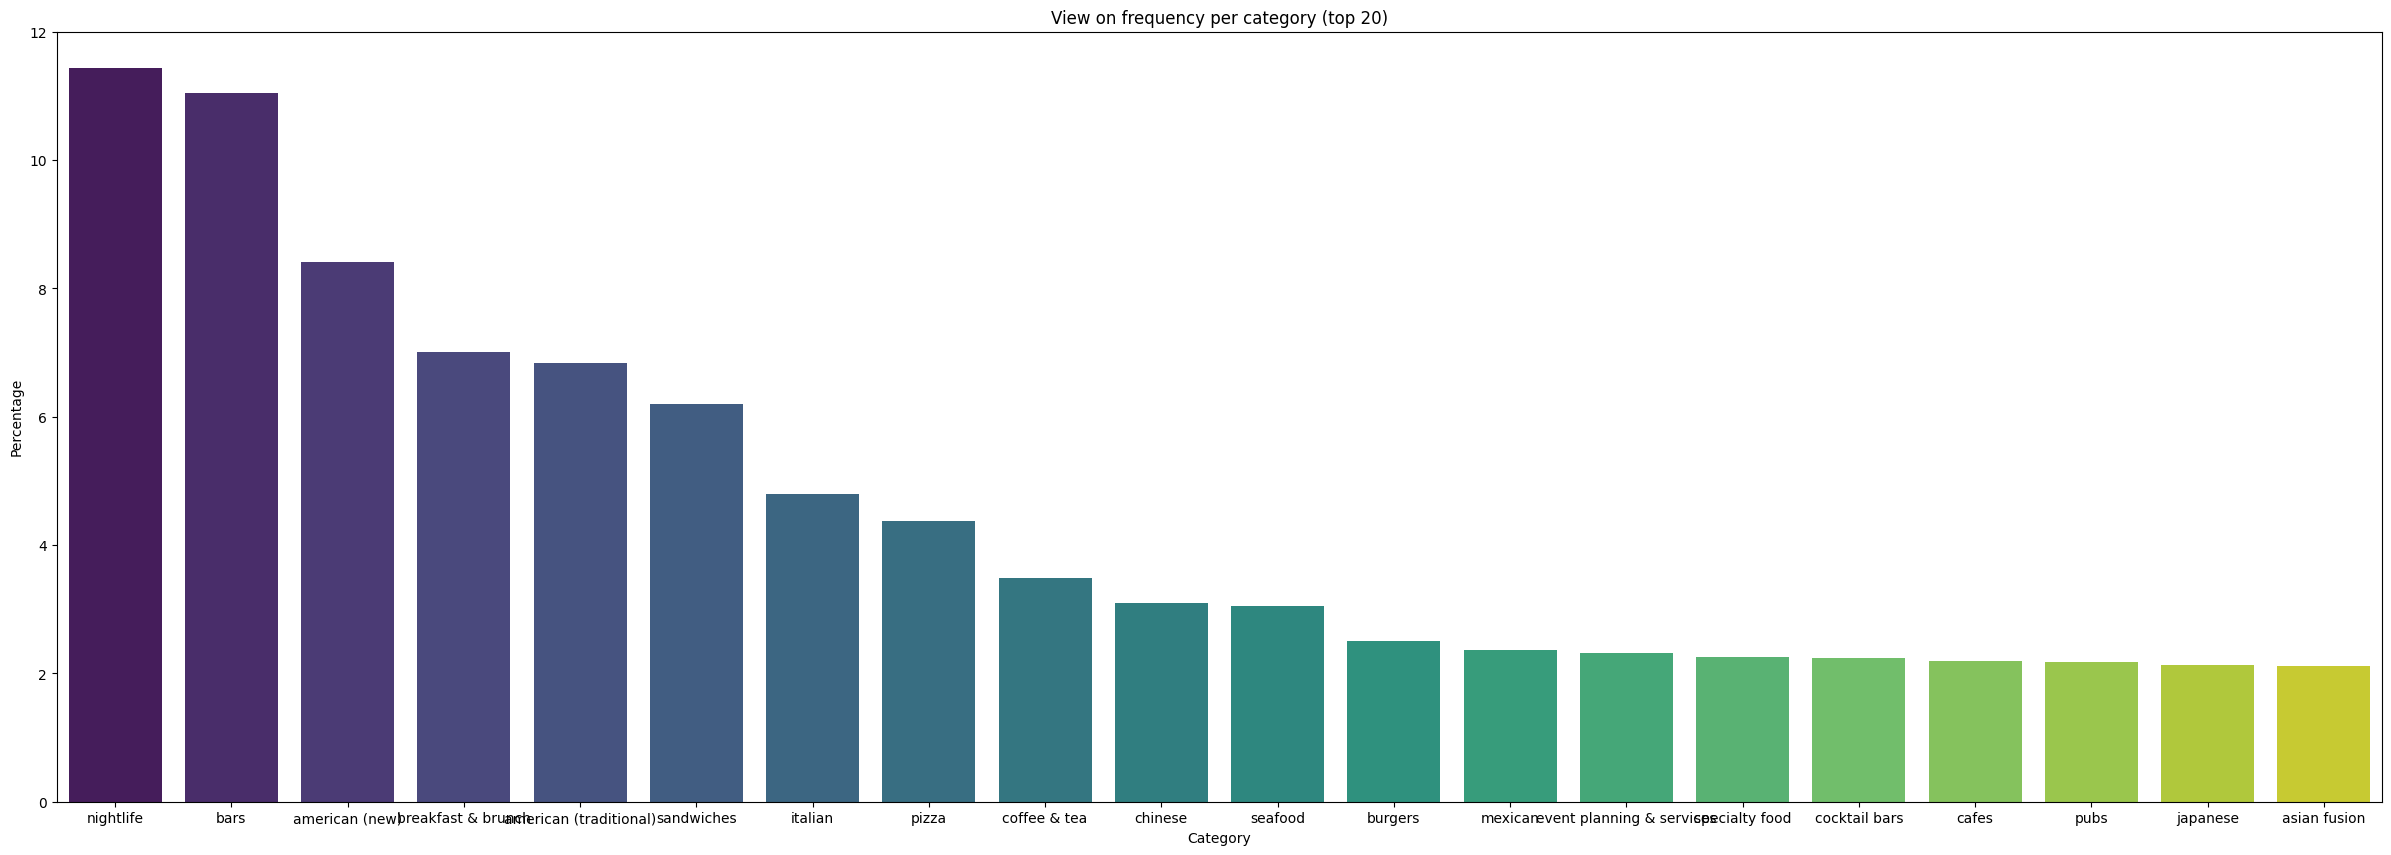

In [21]:
############################################################
# Percentage per category
category_counts = categories_individ_df["categories_list"].value_counts()
category_percent = (category_counts / category_counts.sum()) * 100

# Plot
category_perct_df = category_percent.reset_index()
category_perct_df.columns = ["category", "percentage"]
plt.figure(figsize=(30, 10))
plt.title("View on frequency per category (top 20)")
sns.barplot(x="category", y="percentage", data=category_perct_df[:20], palette="viridis")
plt.xlabel("Category")
plt.ylabel("Percentage")
plt.show()

Let's look now at ratings. We average them to see the top scores. Nothing insightfull seems to appear as the scores are rather homogeneous. We note however a preferrence for specialty food and different types of cuisine (asian, italian, mexican). For beverage it seems that cafes and restaurant associated to beer are liked.

C:\Users\Alexis\AppData\Local\Temp\ipykernel_2200\1391953184.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="categories_list", y="rating", data=mean_ratings[:20], palette="viridis")


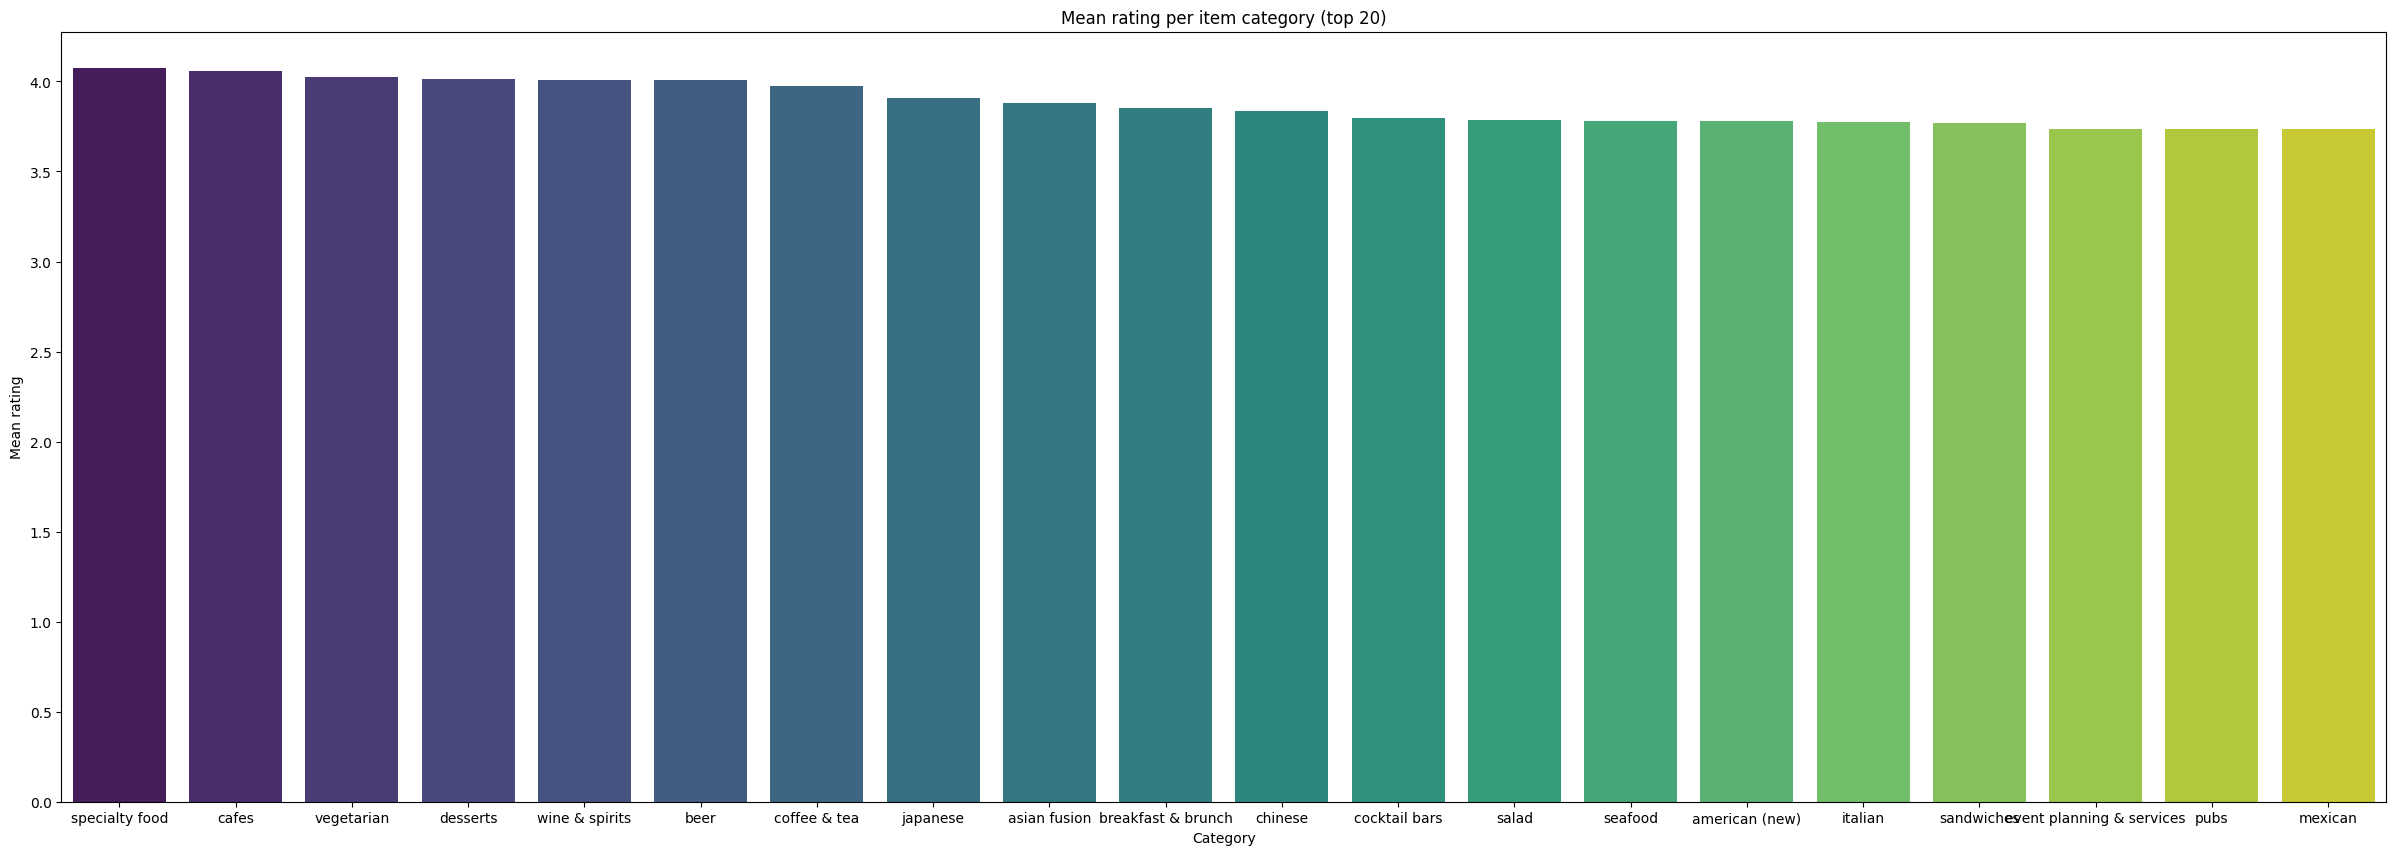

In [22]:
# Averaging the ratings per category

# Plot
mean_ratings = categories_individ_df.groupby("categories_list")["rating"].mean().reset_index()
mean_ratings = mean_ratings.sort_values(by="rating", ascending=False)
plt.figure(figsize=(30, 10))
plt.title("Mean rating per item category (top 20)")
sns.barplot(x="categories_list", y="rating", data=mean_ratings[:20], palette="viridis")
plt.xlabel("Category")
plt.ylabel("Mean rating")
plt.show()

We change the approach slightly and apply a score comparison by diving into the groups in order to compare similar categories and potentially avoid the general homogenization effect. We note that this brings no significant change. As a result, we will have to change our approach and increase compelxity by applying some filters for example.

In [23]:
# Mean rating per category
mean_ratings["group_category"] = mean_ratings["categories_list"].map(CategoryLabel)
mean_ratings = mean_ratings.groupby(["group_category", "categories_list"])["rating"].mean().reset_index()
mean_ratings[mean_ratings["rating"] >= 4].sort_values(by=["group_category","rating", ], ascending=[False, False]).head(15)

,group_category,categories_list,rating
21,cuisine type,specialty food,4.072430
9,cuisine type,cafes,4.055706
22,cuisine type,vegetarian,4.024505
12,cuisine type,desserts,4.011555
6,cuisine type,beer,4.008834
3,ambiance,wine & spirits,4.008834


C:\Users\Alexis\AppData\Local\Temp\ipykernel_2200\1706143992.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="categories_list", y="rating", data=df_ft[:20], palette="viridis")


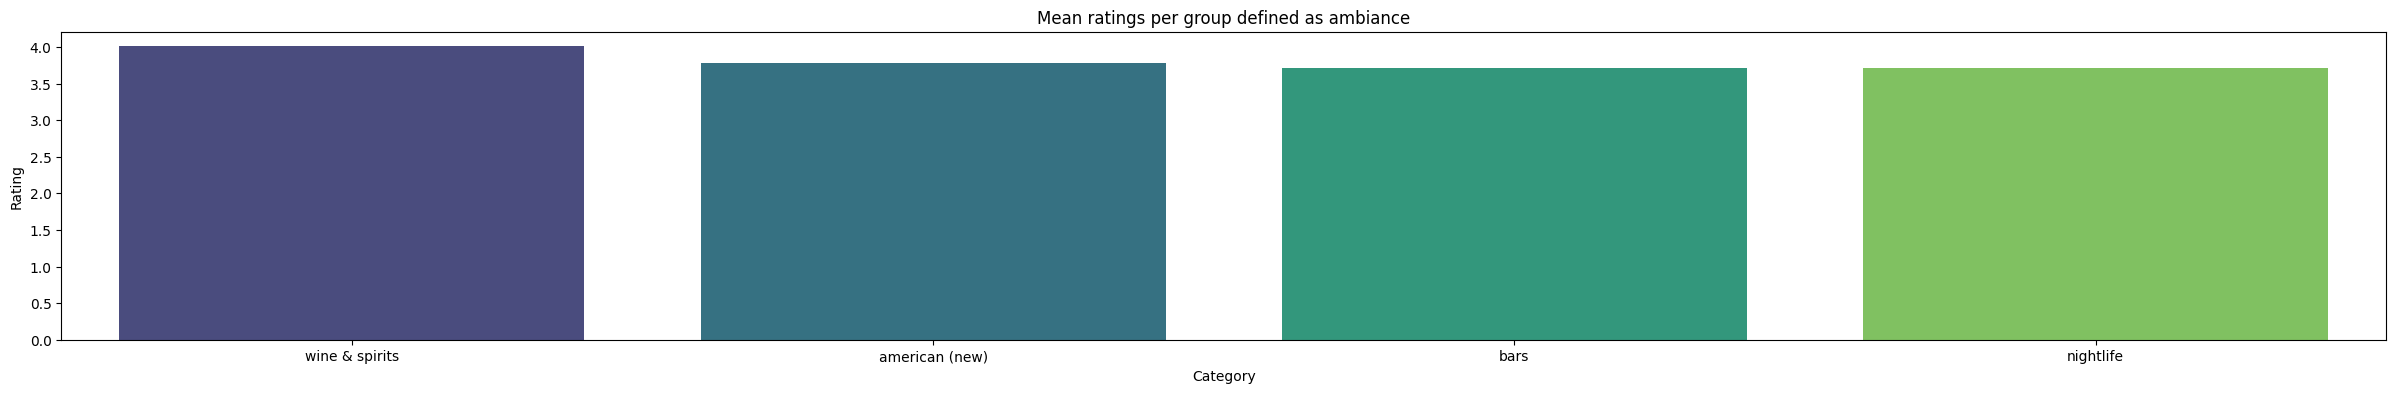

C:\Users\Alexis\AppData\Local\Temp\ipykernel_2200\1706143992.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="categories_list", y="rating", data=df_ft[:20], palette="viridis")


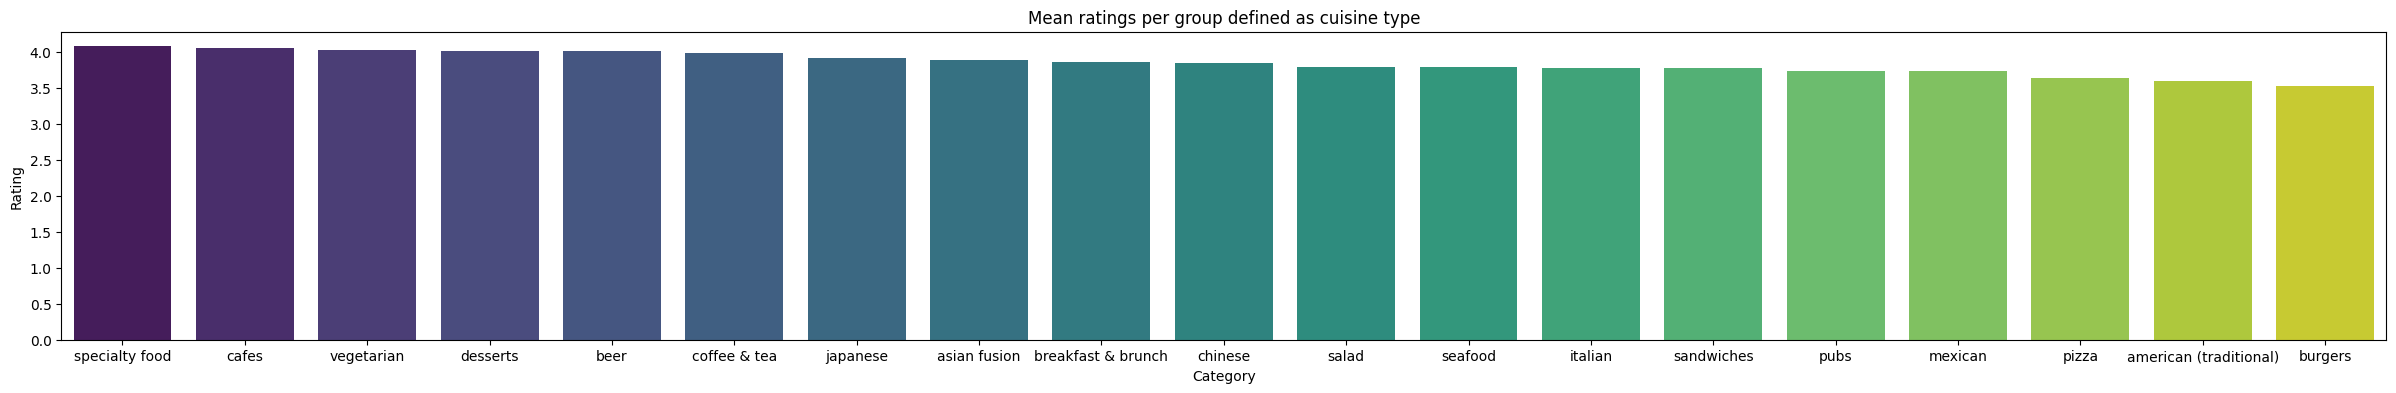

C:\Users\Alexis\AppData\Local\Temp\ipykernel_2200\1706143992.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="categories_list", y="rating", data=df_ft[:20], palette="viridis")


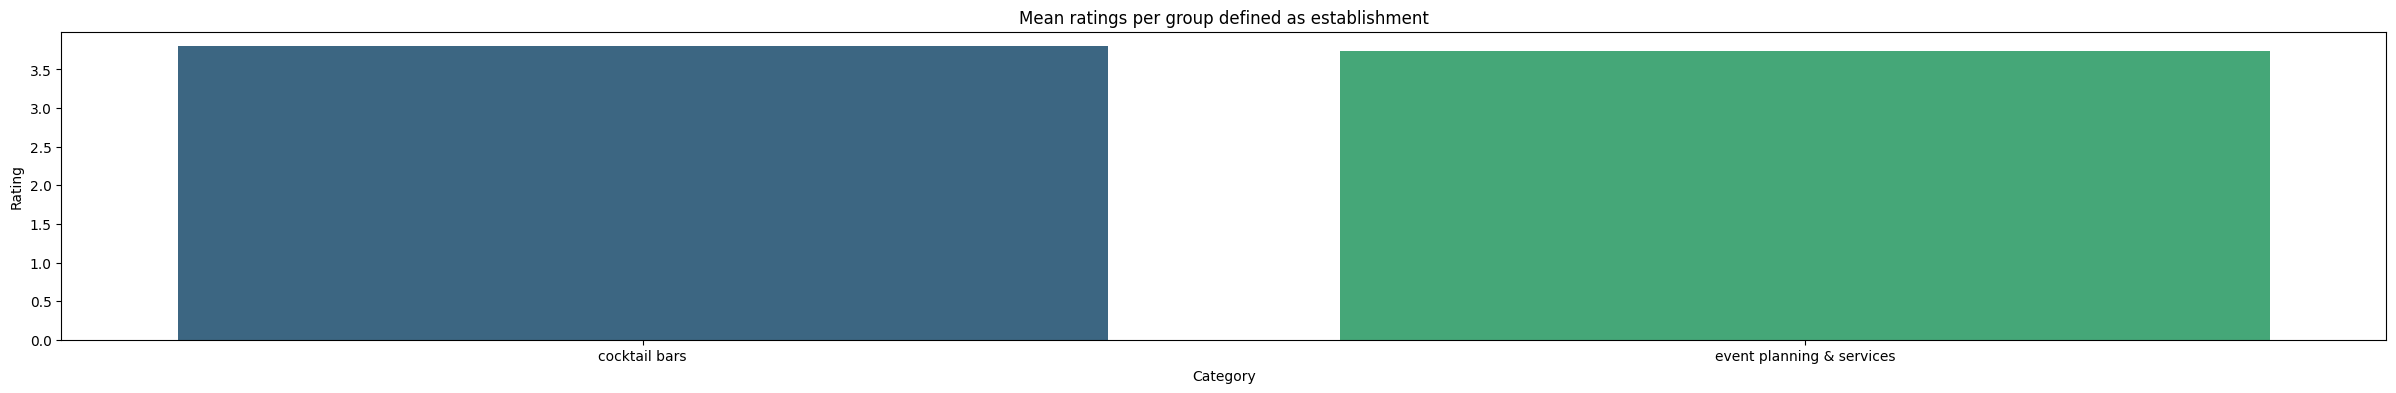

In [24]:
# Bar plots per group
for group in mean_ratings["group_category"].unique():
    df_ft = mean_ratings[mean_ratings["group_category"] == group]
    df_ft[["categories_list", "rating"]]
    df_ft = df_ft.sort_values(by=["rating"], ascending=False)

    plt.figure(figsize=(30, 4))
    plt.title(f"Mean ratings per group defined as {group}")
    sns.barplot(x="categories_list", y="rating", data=df_ft[:20], palette="viridis")
    plt.xlabel("Category")
    plt.ylabel("Rating")
    plt.show()

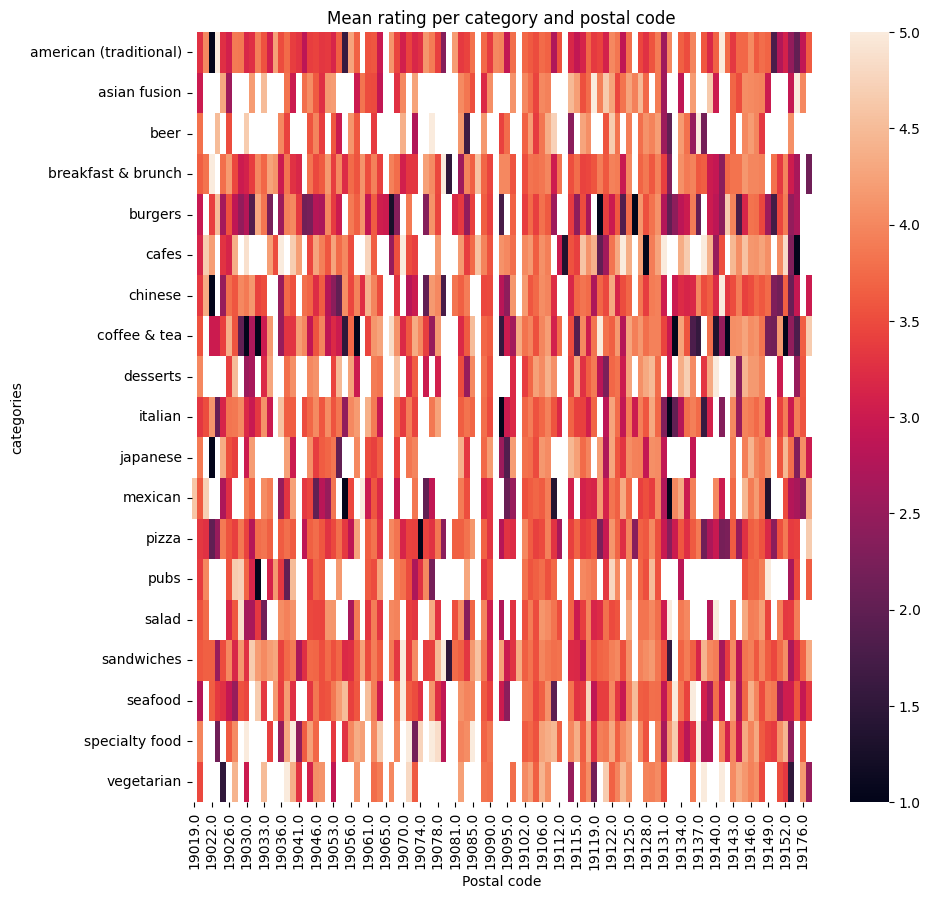

In [25]:
# Heat map per postal code
cuisine_df = categories_individ_df[categories_individ_df["group_categorie"] == "cuisine type"]
df_postalcode = cuisine_df.groupby(["categories_list", "postal_code_int"])["rating"].mean().reset_index().sort_values(by='postal_code_int')
plt.figure(figsize=(10, 10))
sns.heatmap(df_postalcode.pivot(index="categories_list", columns="postal_code_int", values="rating"))
plt.title("Mean rating per category and postal code")
plt.xlabel("Postal code")
plt.ylabel("categories")
plt.show()

Before changing our approach, let's look at the average scores by zip code.This is a very interesting first piece of information. We can see that some postcodes lack categories and are therefore potentially ignored by consumers, while others are associated with almost all types of restaurant. 

#### Approach 2 - keeping reviews judged useful at least 5 times

We can apply a filtering on the reviews to keep only the ones that have been judged "useful" and see how this new constraint affect the rankings. Doing it keep reviews rather important to the public opinion. We need to keep the threshold low to keep a lot of reviews and getting a representative view without excluding business with few reviews, but also high enough to perform a qualitative distinguishment with respect to the previous outputs. Given the large size of our data set and the general homogenization of results, we chose therefore to exclude reviews having not been judged useful or have been judged usful less than 5 times (after having noticed less significant improvement with inferior values). We avoid going to more than 5 times to consider enough reviews...

The next barplot shows that food such as sandwiches, italian cuisine, pizza, breakfast and brunch type of restaurants are getting a lot of reviews.

C:\Users\Alexis\AppData\Local\Temp\ipykernel_2200\1619558882.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="category", y="percentage", data=category_perct_df[:20], palette="viridis")


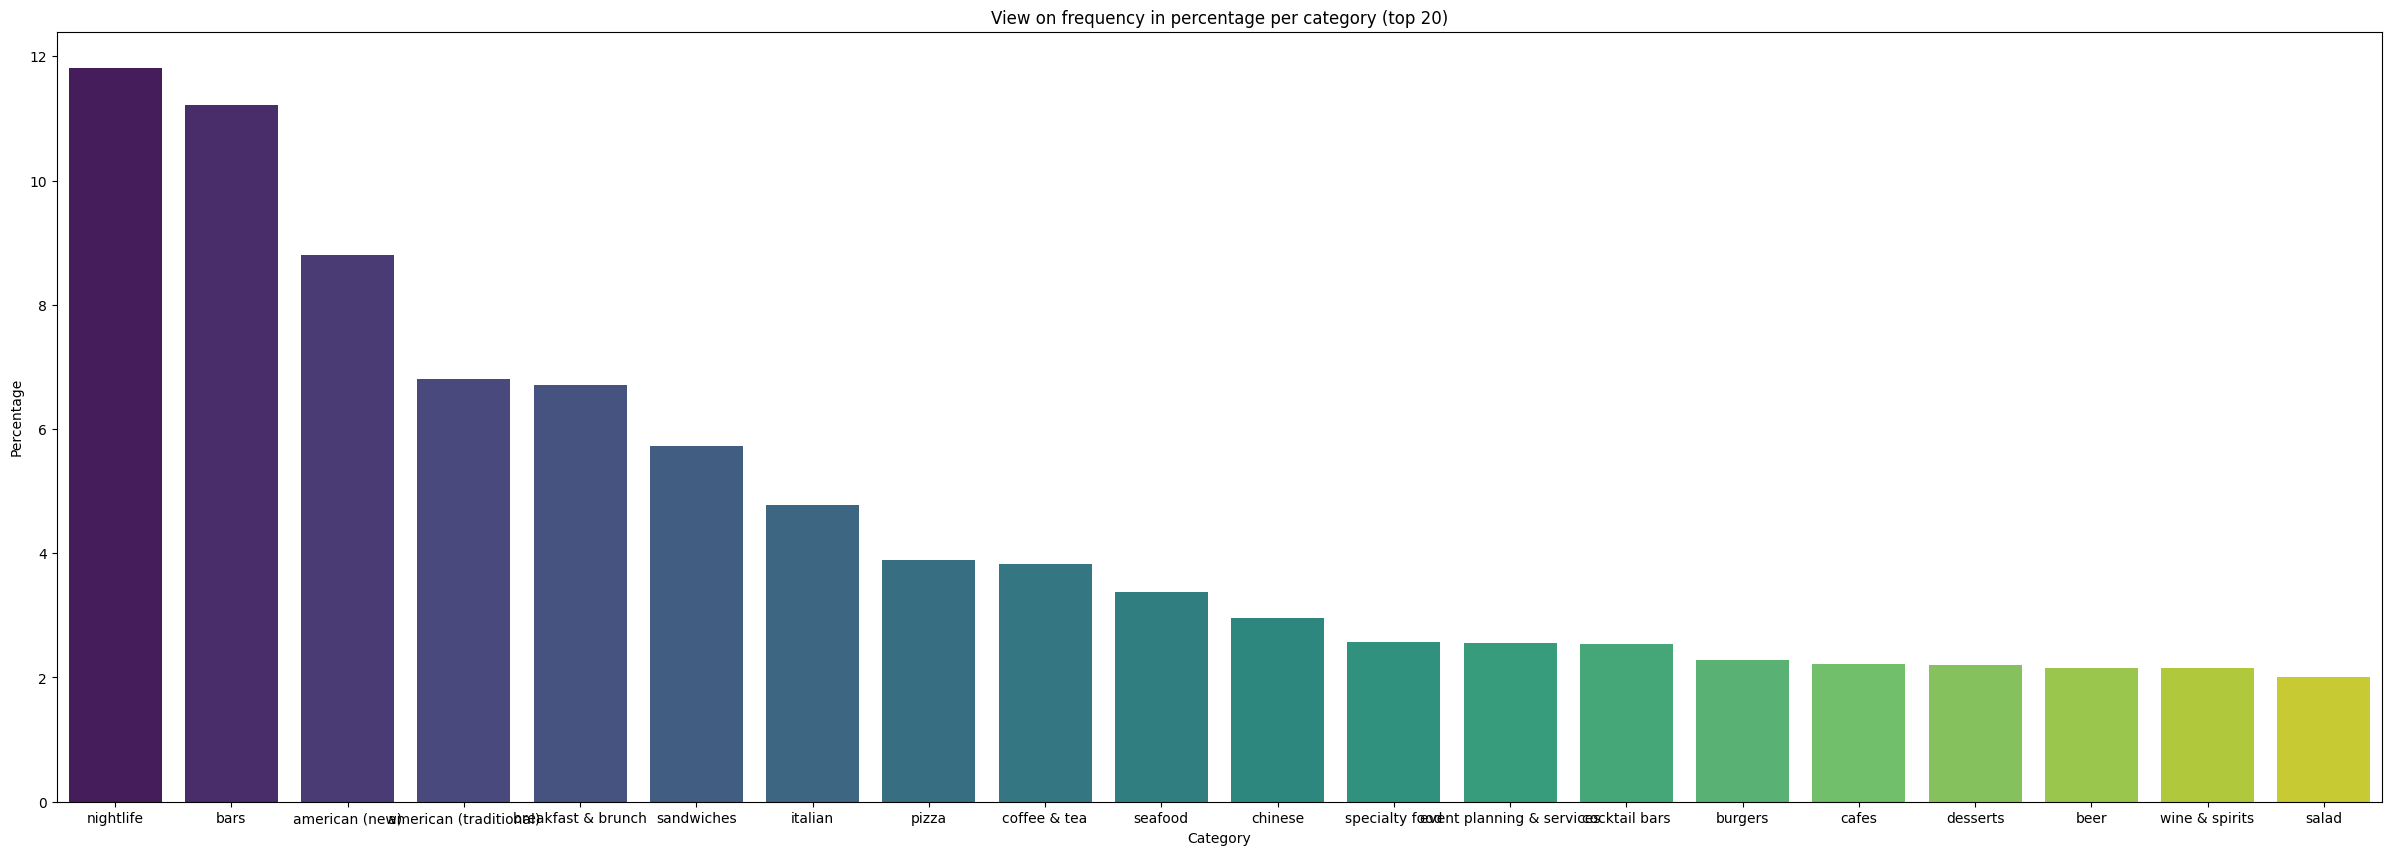

In [26]:
# Keep score in useful >= 3
df_data_utility = categories_individ_df[categories_individ_df["useful"] >= 5]

# Percentage
category_counts = df_data_utility["categories_list"].value_counts()
category_percent = (category_counts / category_counts.sum()) * 100

# Plot
category_perct_df = category_percent.reset_index()
category_perct_df.columns = ["category", "percentage"]
plt.figure(figsize=(30, 10))
sns.barplot(x="category", y="percentage", data=category_perct_df[:20], palette="viridis")
plt.title("View on frequency in percentage per category (top 20)")
plt.xlabel("Category")
plt.ylabel("Percentage")
plt.show()

We observed that ranking changed with respect to the wide analysis. We see that we can play with the importance assigned to reviews to keep more qualitative reviews.

C:\Users\Alexis\AppData\Local\Temp\ipykernel_2200\2424153314.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="categories_list", y="rating", data=mean_ratings[:20], palette="viridis")


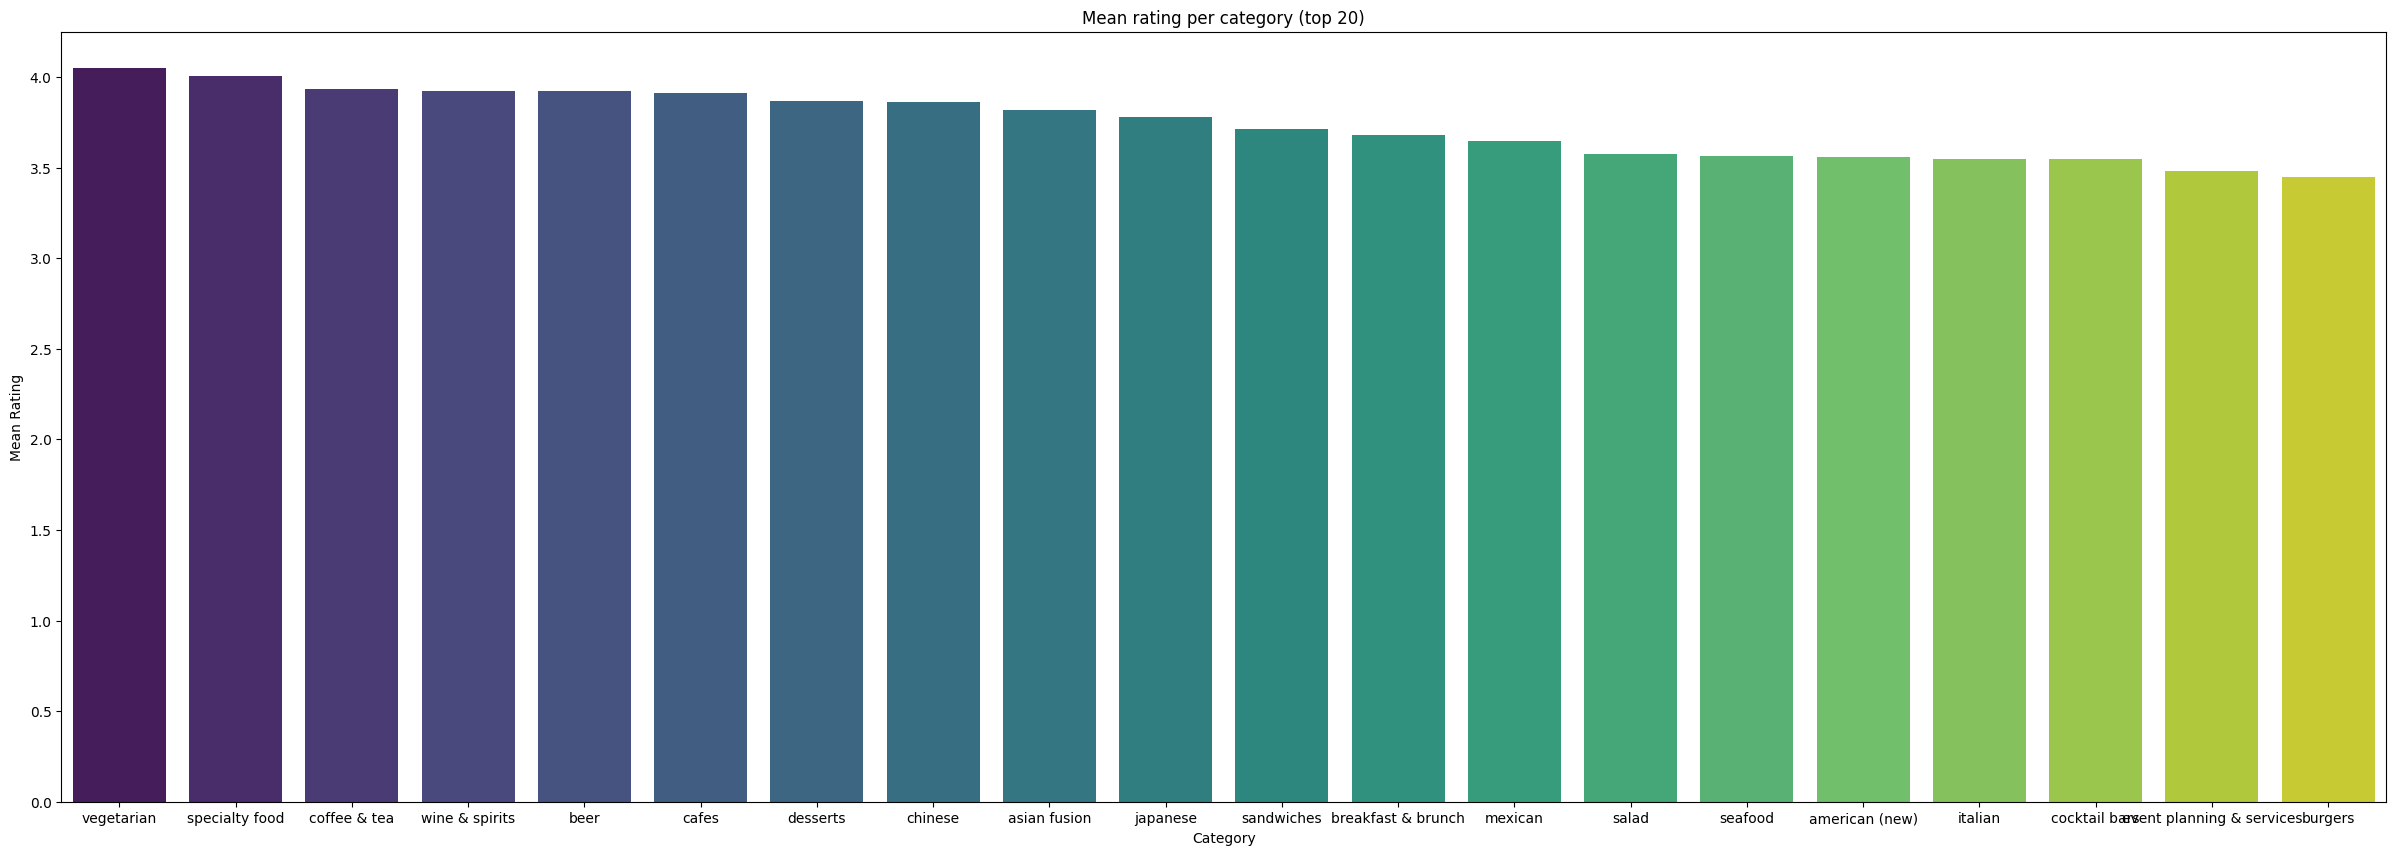

In [27]:
# Plot
mean_ratings = df_data_utility.groupby("categories_list")["rating"].mean().reset_index()
mean_ratings = mean_ratings.sort_values(by="rating", ascending=False)
plt.figure(figsize=(30, 10))
plt.title("Mean rating per category (top 20)")
sns.barplot(x="categories_list", y="rating", data=mean_ratings[:20], palette="viridis")
plt.xlabel("Category")
plt.ylabel("Mean Rating")
plt.show()

When we compare the two heatmaps, we can see some preferences among reviews for certain type of food such as Chicken wings, meditarenean or indian food. This approach show that these types of food give frequent and better reviews in general. Also, we see that some postcodes are no longer deserved, and we see better a bit btter which categories continue to be served. From the heatmaps we see now for example that reviews concentrates on postal codes such as 19103, 1907, 19146 or 19147... The offer and the demand seems to concentrate there. 

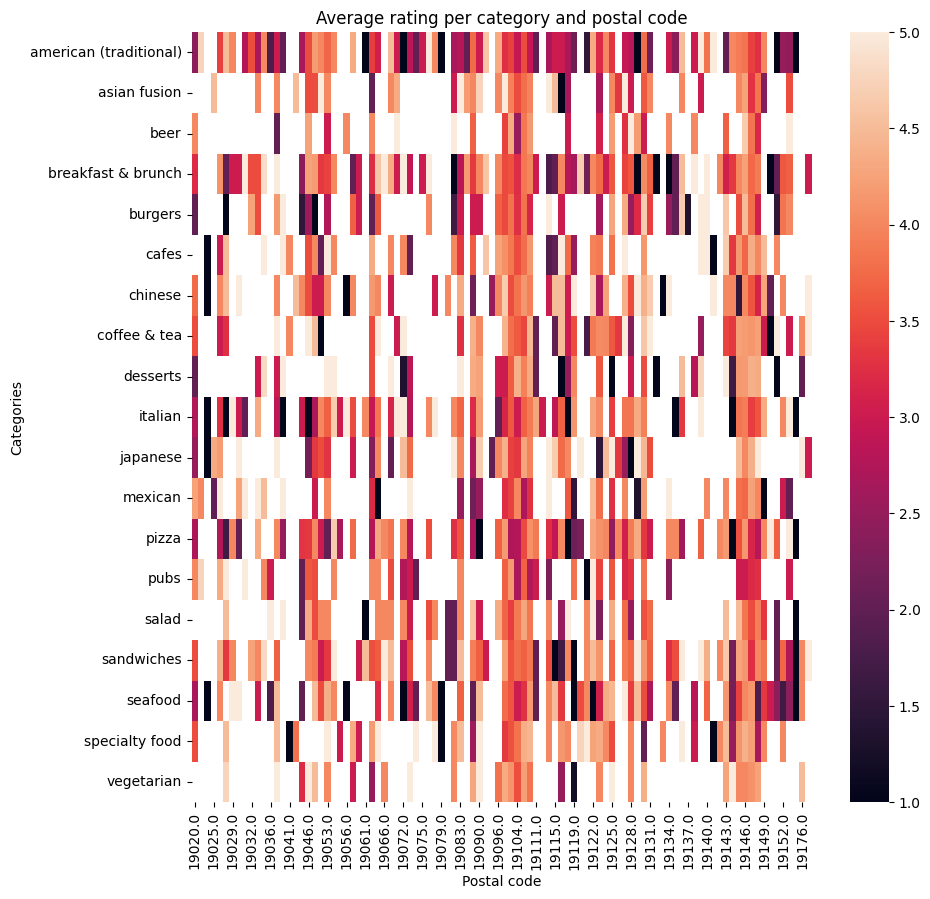

In [29]:
# Heat map per postal code
cuisine_df = df_data_utility[df_data_utility["group_categorie"] == "cuisine type"]
df_postalcode = cuisine_df.groupby(["categories_list", "postal_code_int"])["rating"].mean().reset_index()
plt.figure(figsize=(10, 10))
sns.heatmap(df_postalcode.pivot(index="categories_list", columns="postal_code_int", values="rating"))
plt.title("Average rating per category and postal code")
plt.xlabel("Postal code")
plt.ylabel("Categories")
plt.show()

#### Focus on attributes

#### Approach 1 - Wide

We replicate the same steps as seen for categories, but this time with attributes.

In [31]:
# Reinitializing the dataset
df_data = pd.read_csv("data/df_data_final.csv", header=0)
df_data['categories_list'] = df_data['categories_list'].apply(ast.literal_eval)
df_data['attributes_list'] = df_data['attributes_list'].apply(ast.literal_eval)

# Split the dataset per attribute and remove observations with rare attributes
attribute_individ_df = df_data.explode("attributes_list")
attribute_individ_df = attribute_individ_df[~attribute_individ_df["attributes_list"].isin(data_attr_rare)]

# Put attributes in a set
all_attributes = set(np.concatenate(df_data.attributes_list.values).ravel())

In [33]:
# Group attributes  
group_names = ["facilities","food", "service", "atmosphere"]
Attribute_groups = {}

# Classify the attributes according to the groups
for category in all_attributes:
    output = classifier(category, group_names)
    Attribute_groups[category] = output["labels"][0]

attribute_individ_df["group_attribute"] = attribute_individ_df["attributes_list"].map(Attribute_groups)

KeyboardInterrupt: 

#### Frequency of items in attributes

C:\Users\ady\AppData\Local\Temp\ipykernel_13592\1554998907.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes_list", y="rating", data=mean_ratings[:20], palette="viridis")


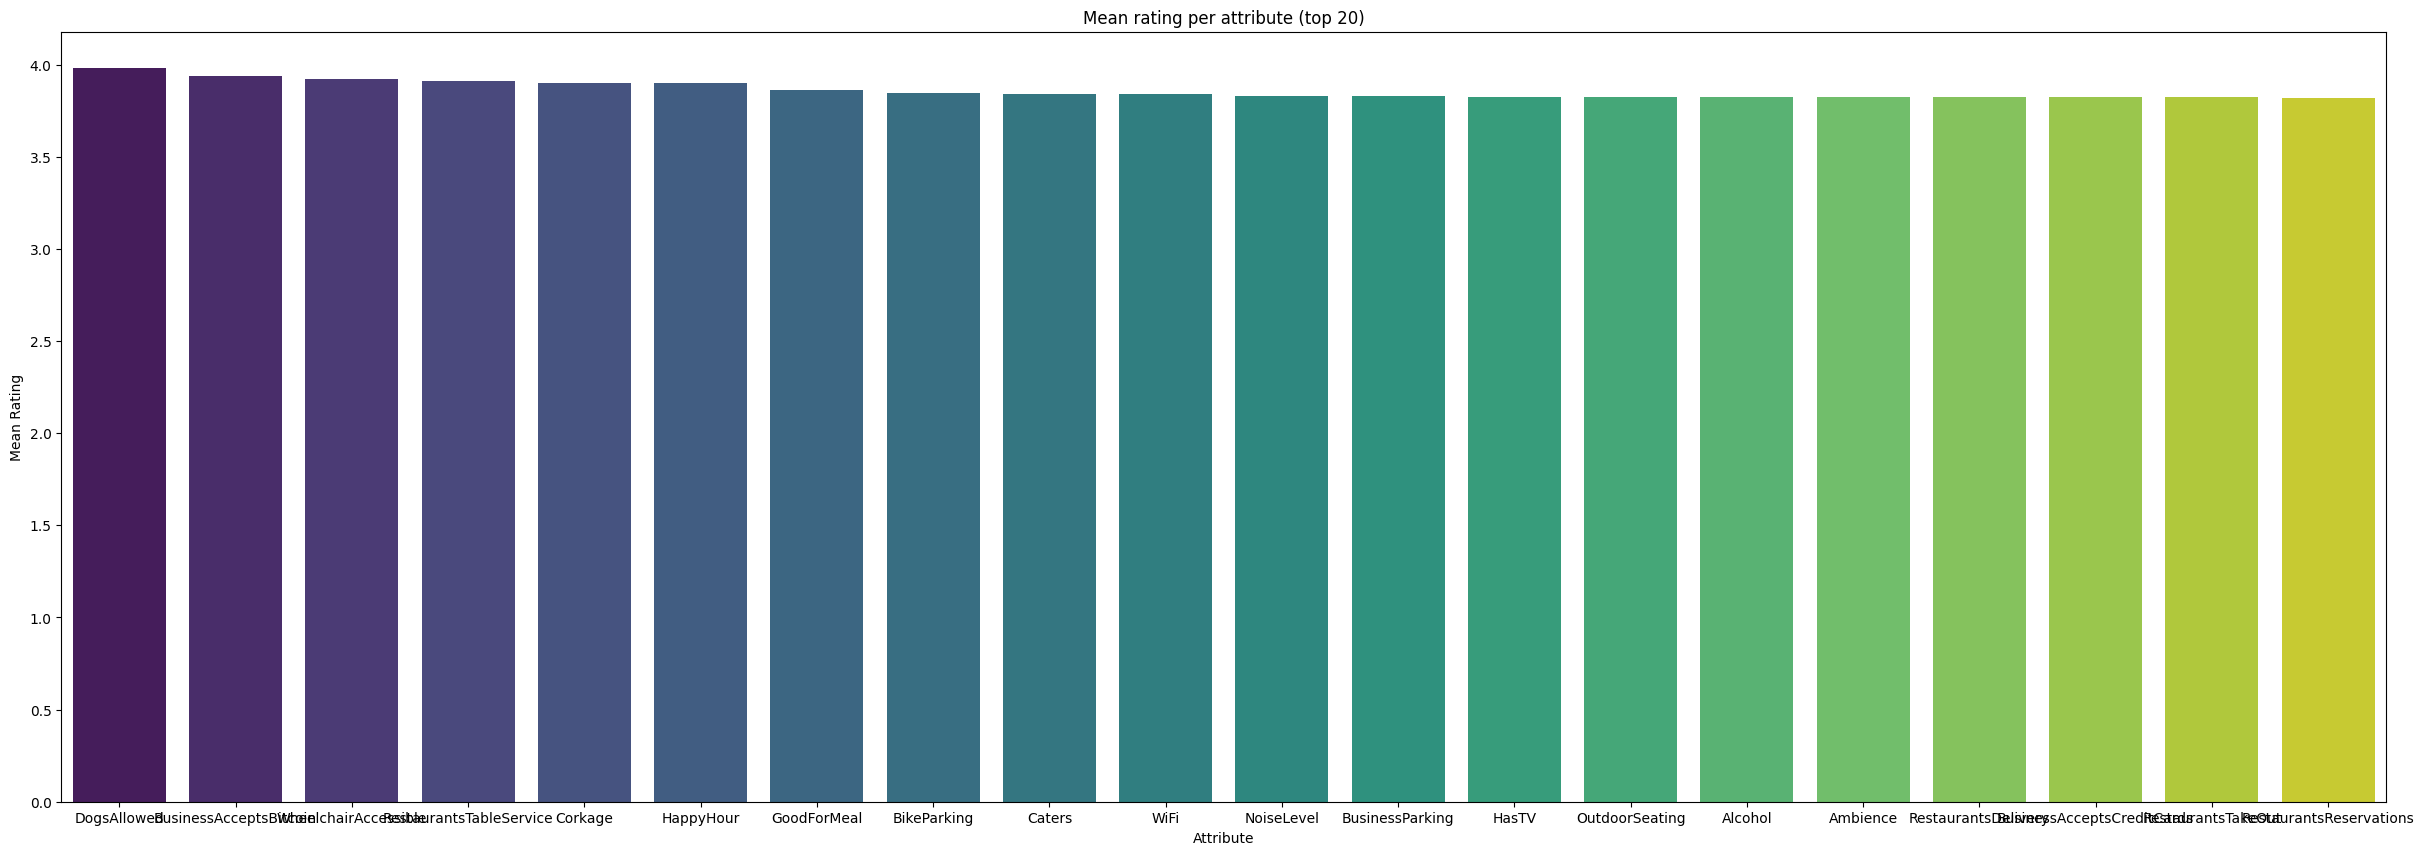

C:\Users\ady\AppData\Local\Temp\ipykernel_13592\1554998907.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes", y="percentage", data=attribute_percentages_df[:20], palette="viridis")


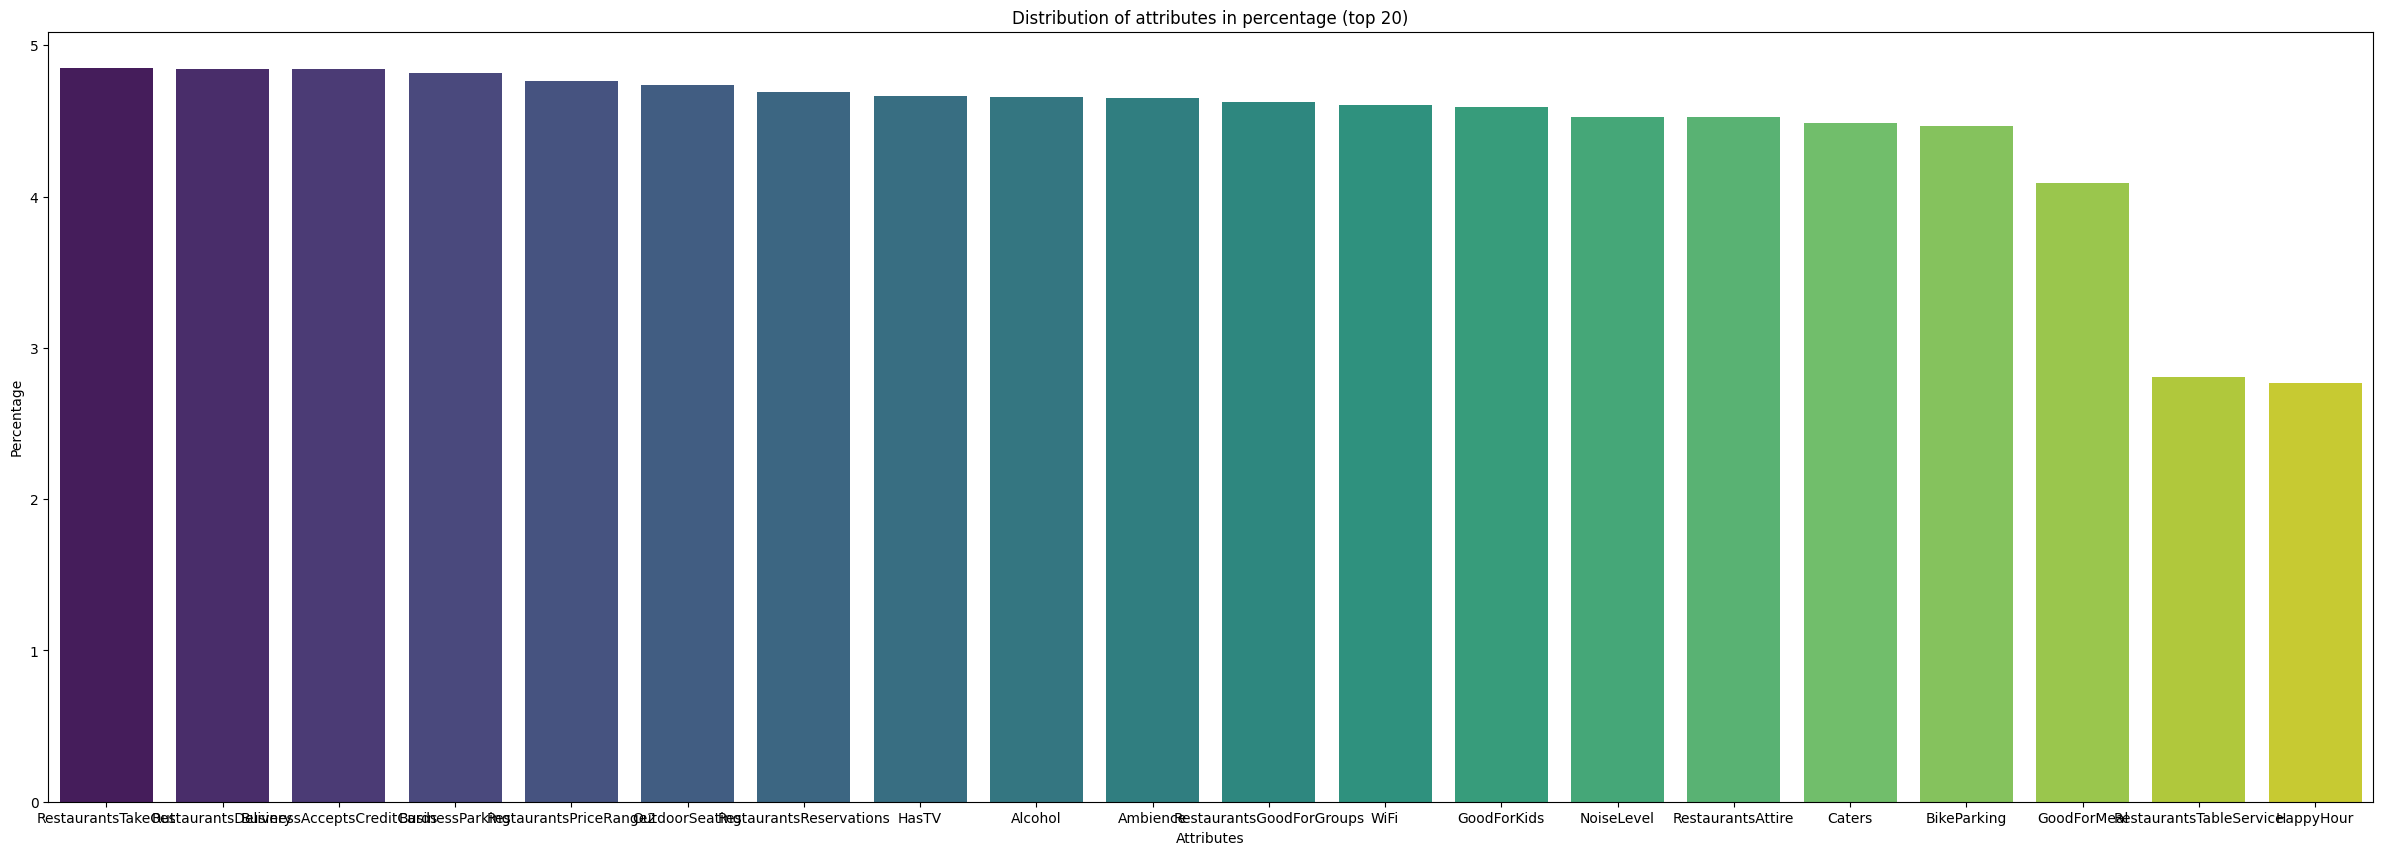

In [ ]:
##################################################################
# Calculate the percentage distribution
attribute_counts = attribute_individ_df["attributes_list"].value_counts()
attribute_percentages = (attribute_counts / attribute_counts.sum()) * 100

# Plot the results
attribute_percentages_df = attribute_percentages.reset_index()
attribute_percentages_df.columns = ["attributes", "percentage"]
plt.figure(figsize=(30, 10))
plt.title("View on frequency in percentage per attribute (top 20)")
sns.barplot(x="attributes", y="percentage", data=attribute_percentages_df[:20], palette="viridis")
plt.xlabel("Attribute")
plt.ylabel("Percentage")
plt.show()

In [ ]:
##################################################################
# AVERAING PER attribute

# Plot the results
mean_ratings = attribute_individ_df.groupby("attributes_list")["rating"].mean().reset_index()
mean_ratings = mean_ratings.sort_values(by="rating", ascending=False)
plt.figure(figsize=(30, 10))
plt.title("Mean rating per attribute (top 20)")
sns.barplot(x="attributes_list", y="rating", data=mean_ratings[:20], palette="viridis")
plt.xlabel("Attribute")
plt.ylabel("Rating")
plt.show()



#### Average rating per attribute for reviews judged "useful" at least 2 times

C:\Users\ady\AppData\Local\Temp\ipykernel_13592\210022296.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes_list", y="rating", data=mean_ratings[:20], palette="viridis")


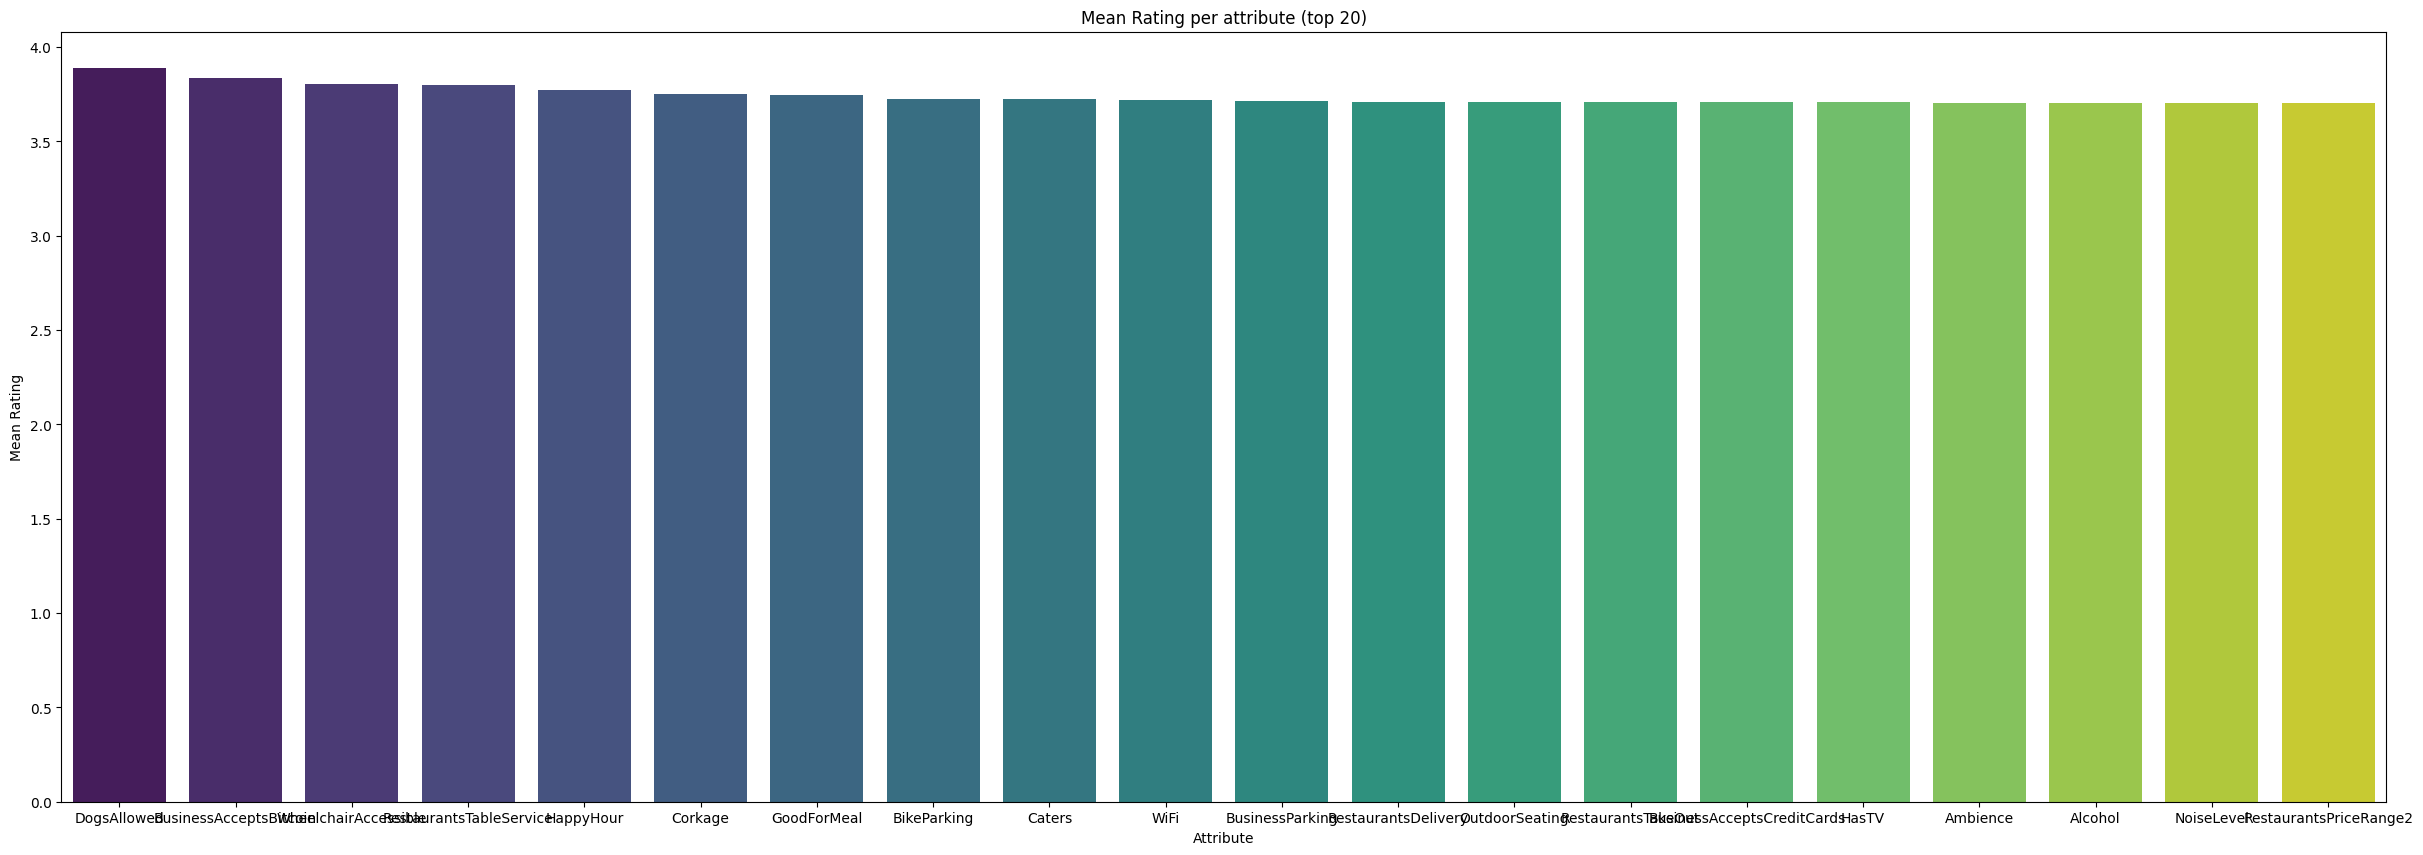

C:\Users\ady\AppData\Local\Temp\ipykernel_13592\210022296.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attribute", y="percentage", data=attribute_percentages_df[:20], palette="viridis")


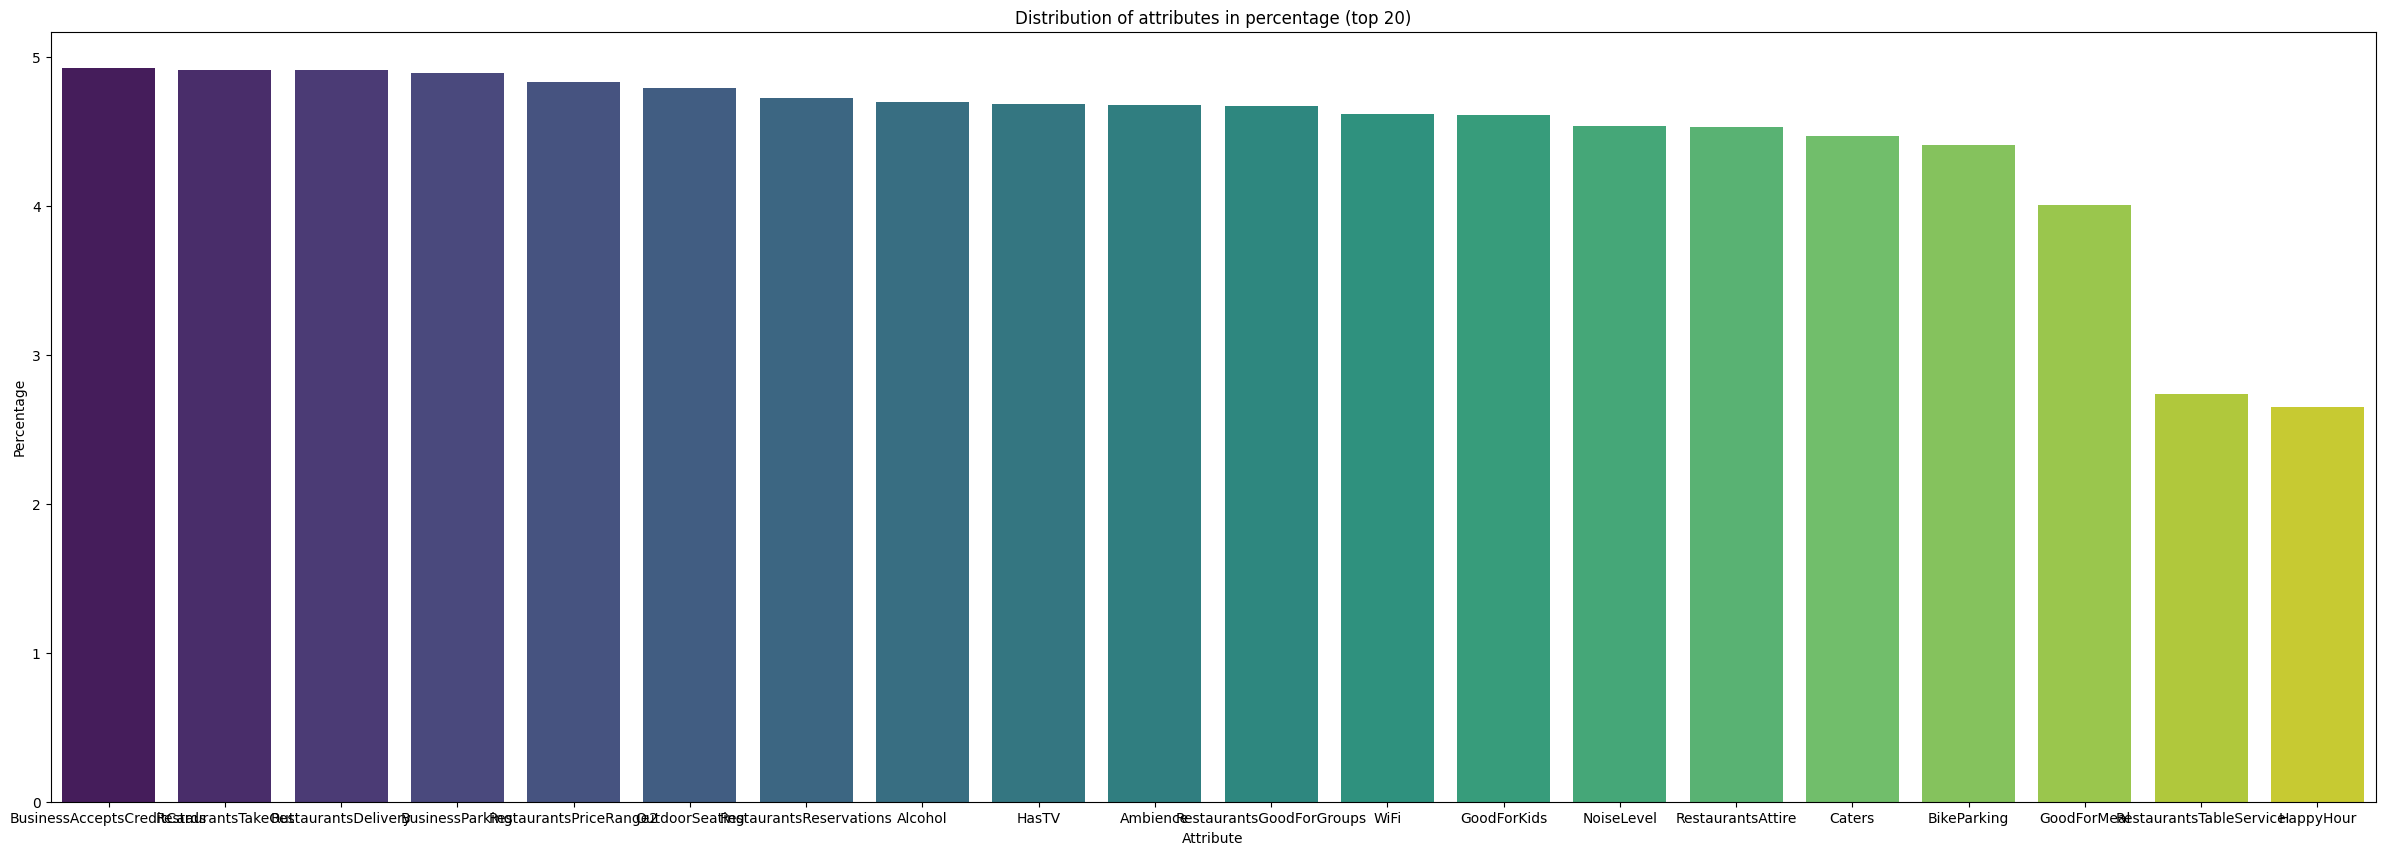

In [ ]:
# Keep utility score >= 5
df_data_utility = attribute_individ_df[attribute_individ_df["useful"] >= 5]
attribute_counts = df_data_utility["attributes_list"].value_counts()
attribute_percentages = (attribute_counts / attribute_counts.sum()) * 100

# Plot RATING
mean_ratings = df_data_utility.groupby("attributes_list")["rating"].mean().reset_index()
mean_ratings = mean_ratings.sort_values(by="rating", ascending=False)
plt.figure(figsize=(30, 10))
plt.title("Mean rating per attribute (top 20)")
sns.barplot(x="attributes_list", y="rating", data=mean_ratings[:20], palette="viridis")
plt.xlabel("Attribute")
plt.ylabel("Mean rating")
plt.show()


# Plot FREQUENCY
attribute_percentages_df = attribute_percentages.reset_index()
attribute_percentages_df.columns = ["attribute", "percentage"]
plt.figure(figsize=(30, 10))
plt.title("View of frequency in percentage per attribute (top 20)")
sns.barplot(x="attribute", y="percentage", data=attribute_percentages_df[:20], palette="viridis")
plt.xlabel("Attribute")
plt.ylabel("Percentage")
plt.show()

#### PLOT PER GROUP ATTRIBUTE

In [ ]:
# Mean rating per category
mean_ratings["group_attribute"] = mean_ratings["attributes_list"].map(Attribute_groups)
mean_ratings = mean_ratings.groupby(["group_attribute", "attributes_list"])["rating"].mean().reset_index()
mean_ratings = mean_ratings.sort_values(by=["group_attribute", "rating"], ascending=False)
mean_ratings.head(10)

,group_attribute,attributes_list,rating
20,service,DogsAllowed,3.887022
18,service,BusinessAcceptsBitcoin,3.836552
26,service,RestaurantsTableService,3.798852
22,service,HappyHour,3.775077
27,service,WiFi,3.719888
25,service,RestaurantsDelivery,3.711306
19,service,BusinessAcceptsCreditCards,3.707289
23,service,HasTV,3.706240
16,service,Alcohol,3.704138
24,service,NoiseLevel,3.703614


C:\Users\ady\AppData\Local\Temp\ipykernel_13592\4211424680.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes_list", y="rating", data=df_filt[:20], palette="viridis")


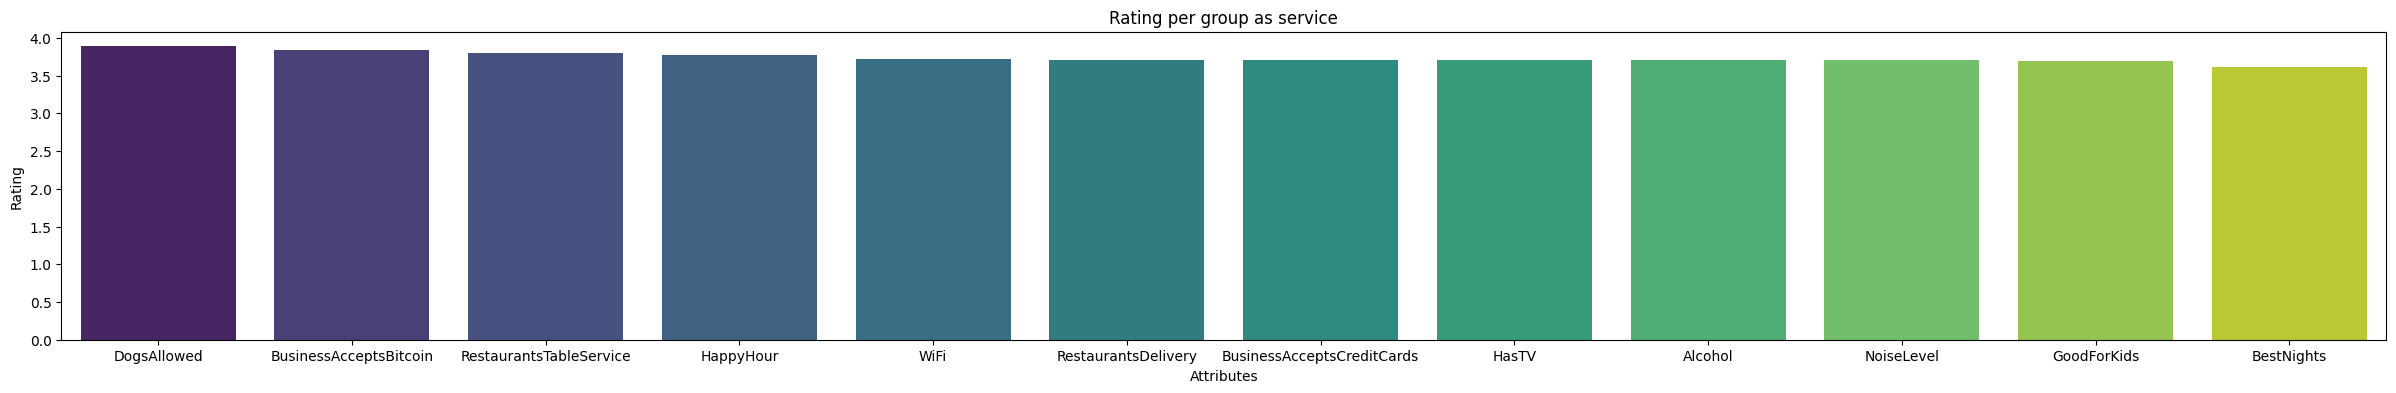

C:\Users\ady\AppData\Local\Temp\ipykernel_13592\4211424680.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes_list", y="rating", data=df_filt[:20], palette="viridis")


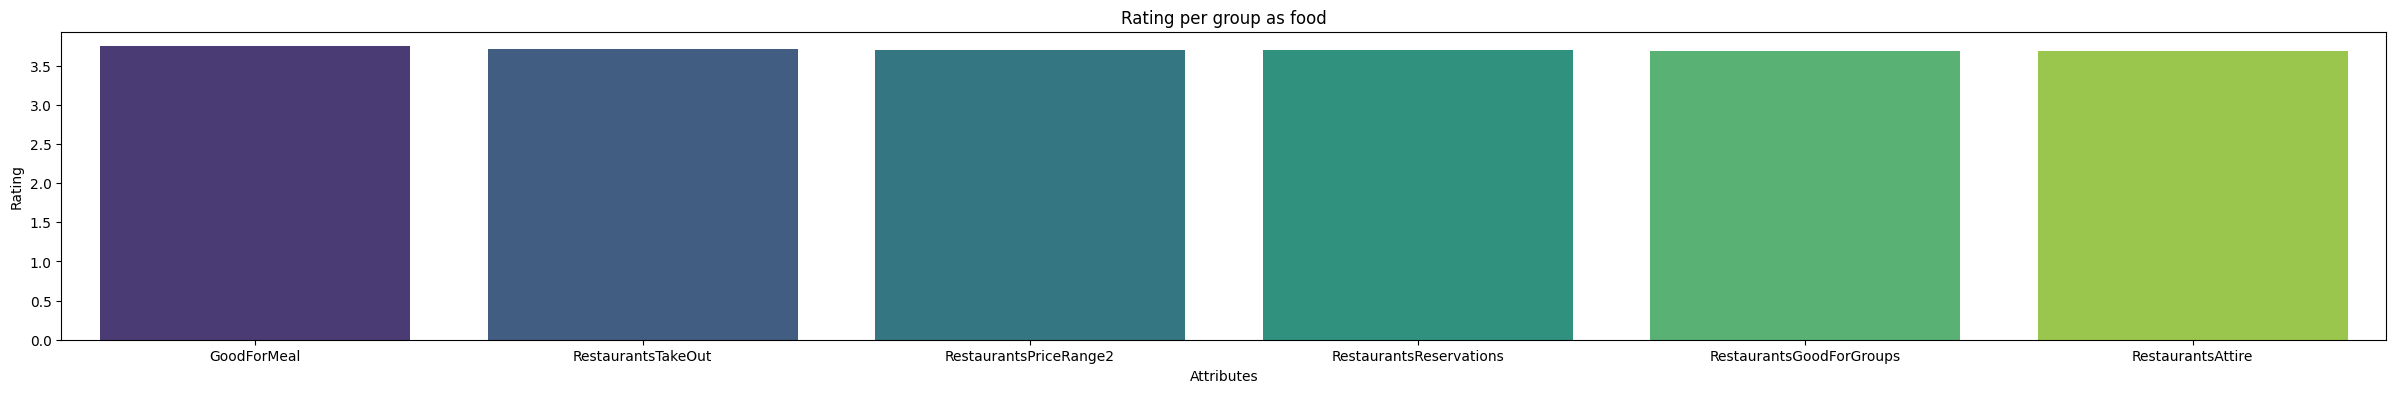

C:\Users\ady\AppData\Local\Temp\ipykernel_13592\4211424680.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes_list", y="rating", data=df_filt[:20], palette="viridis")


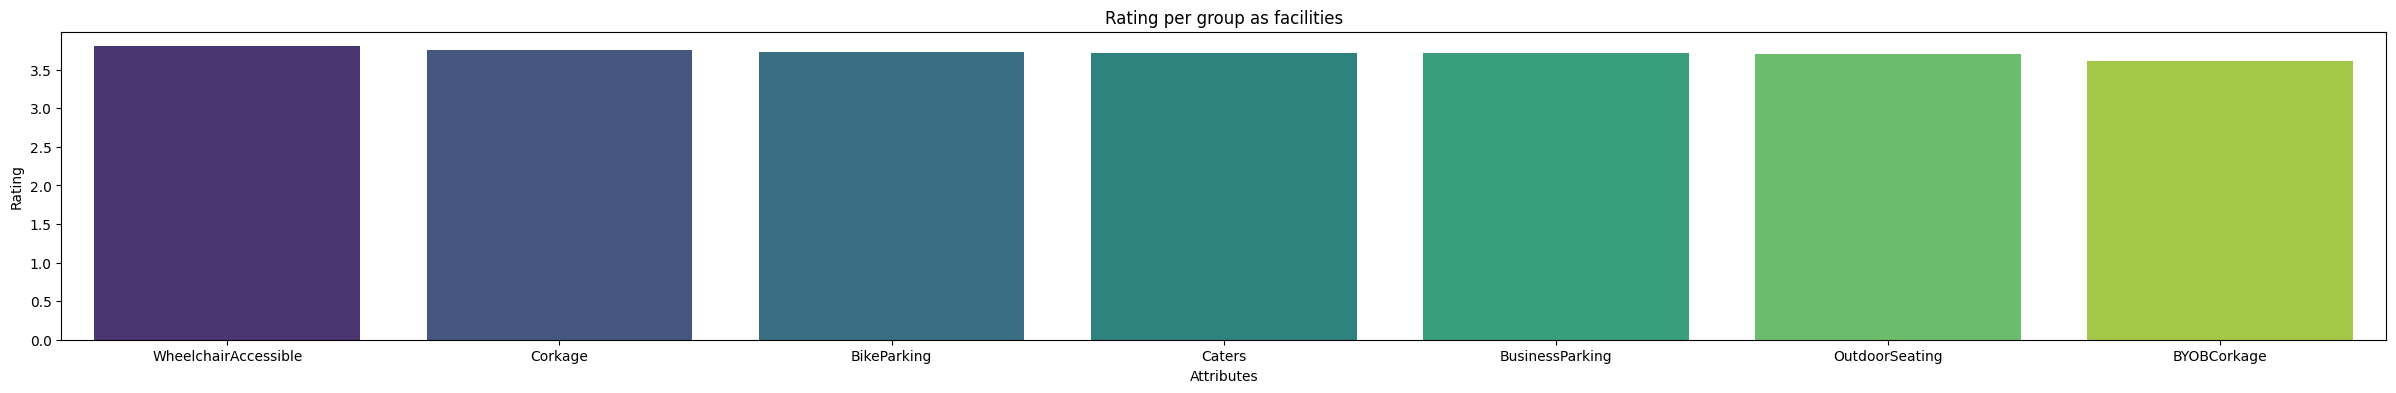

C:\Users\ady\AppData\Local\Temp\ipykernel_13592\4211424680.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes_list", y="rating", data=df_filt[:20], palette="viridis")


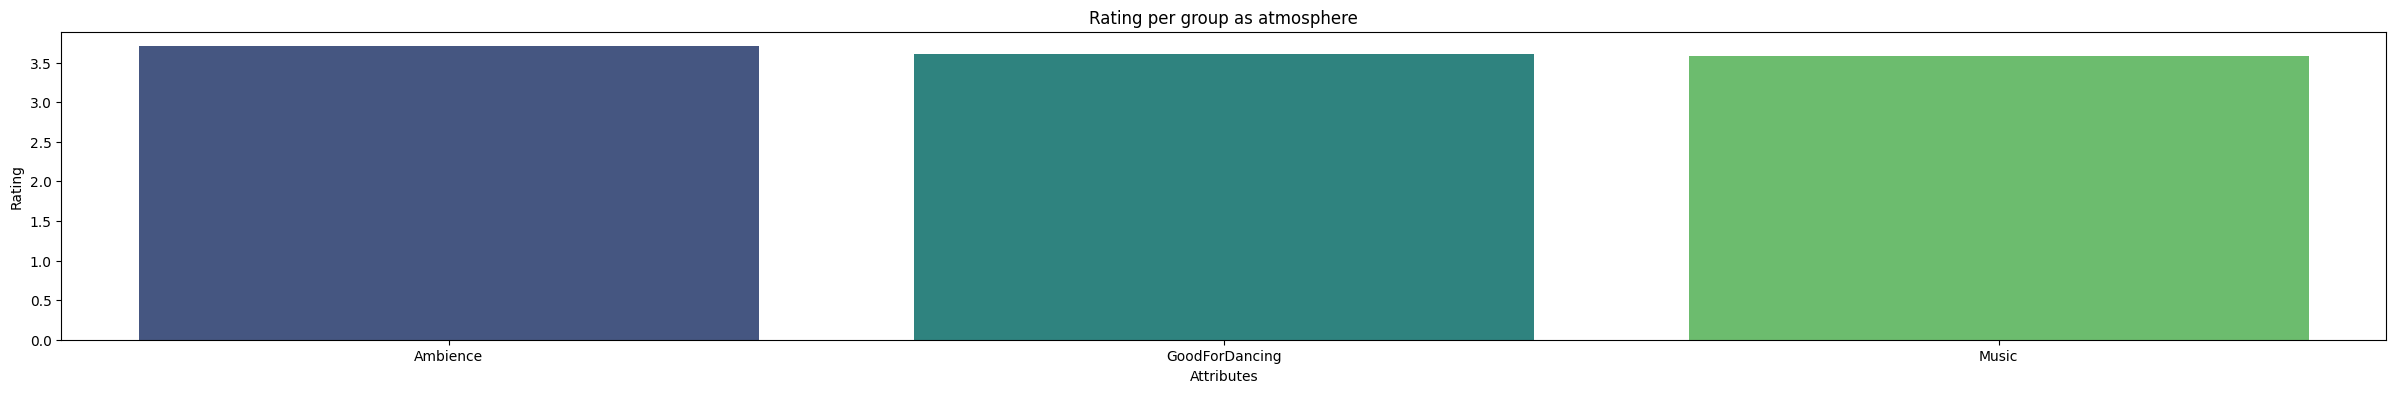

In [ ]:
# Barplots per attribute
for group in mean_ratings["group_attribute"].unique():
    df_filt = mean_ratings[mean_ratings["group_attribute"] == group]
    df_filt[["attributes_list", "rating"]]
    df_filt = df_filt.sort_values(by=["rating"], ascending=False)

    plt.figure(figsize=(30, 4))
    plt.title(f"Rating per group as {group}")
    sns.barplot(x="attributes_list", y="rating", data=df_filt[:20], palette="viridis")
    plt.xlabel("Attributes")
    plt.ylabel("Rating")
    plt.show()

Having filtered the reviews per usefulness we observe.... TO COMPLETE

### 2. Analysis based on sentiments

In the following section we will compute a ranking based on a score obtained by considering the mean of a sentiment analysis of reviews. When a review is judged "POSITIVE" the reviews gets value 1, else 0. Then, an average per category or attribute respectively is computed. The factors are then ranked according to the score obtained. This method is used to consider the sentimental aspect of the review as said. In this way, we obtain a trace of the categories that tend to be associated globally with positive emotions.

#### Approach 1 -  Classic

The analysis is performed in the classical way described above.

In [ ]:
# Compute a mean per category
categories_individ_df.drop(categories_individ_df[categories_individ_df['sentiment'] == "None"].index, inplace = True)
categories_individ_df["sentiment"] = categories_individ_df["sentiment"].replace("NEGATIVE", 0)
categories_individ_df["sentiment"] = categories_individ_df["sentiment"].replace("POSITIVE", 1)
mean_sent_category = categories_individ_df.groupby(["group_categorie", "categories_list"])["sentiment"].mean().reset_index()
mean_sent_category.sort_values(by="sentiment", ascending=False)

# Barplots per category and sentiment
for group in mean_sent_category["group_categorie"].unique():
    df_filt = mean_sent_category[mean_sent_category["group_categorie"] == group]
    df_filt[["categories_list", "sentiment"]]
    df_filt = df_filt.sort_values(by=["sentiment"], ascending=False)

    plt.figure(figsize=(30, 4))
    plt.title(f"Sentiment score per group as {group}")
    sns.barplot(x="categories_list", y="sentiment", data=df_filt[:20], palette="viridis")
    plt.xlabel("Category")
    plt.ylabel("Sentiment")
    plt.show()

AttributeError: 'NoneType' object has no attribute 'drop'

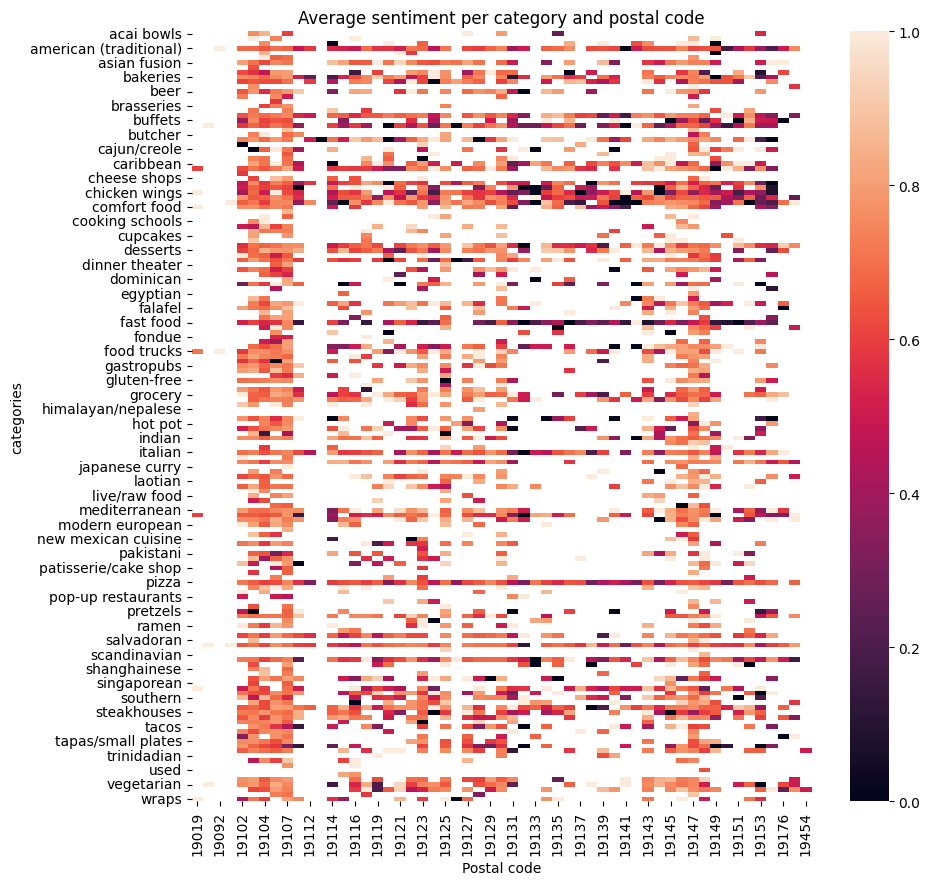

In [ ]:
# Heat map per postal code
cuisine_df = categories_individ_df[categories_individ_df["group_categorie"] == "cuisine type"]
df_postalcode = cuisine_df.groupby(["categories_list", "postal_code"])["sentiment"].mean().reset_index()
plt.figure(figsize=(10, 10))
sns.heatmap(df_postalcode.pivot(index="categories_list", columns="postal_code", values="sentiment"))
plt.title("Average sentiment per category and postal code")
plt.xlabel("Postal code")
plt.ylabel("Category")
plt.show()

#### Approach 2 -  weights given by "useful" dimension.

We try then to see how items changes when assigning more weights to reviews according to the dimension "useful". We should have a better differenciation in the ratings. Therefore, it is as if we relied on the judgment of the crowd to give reviews a special treatment. This is done by simply replicating values according to the number in the column "useful". For example, if review n°1 has a value of 3 in "useful", we replicate it 3 times.

Let's analyse now the similarities of groups with the score based on sentiments and the groups with score based on ratings.

With respect to the group "ambiance", we find that reviews associated to restaurants with category items related to a dimension that is related to music openess, social gathering and relaxation are ranked first. We find for example categories such as karaoke, art, social, spas in the top values...

With respect to the group "cuisine type" which refers to food, it seems that this method does not highlight any pattern.

With respect to the group "establishment" it seems that categories caffes are privilegied.

C:\Users\ady\AppData\Local\Temp\ipykernel_13592\874120165.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="categories_list", y="sentiment", data=df_filt[:20], palette="viridis")


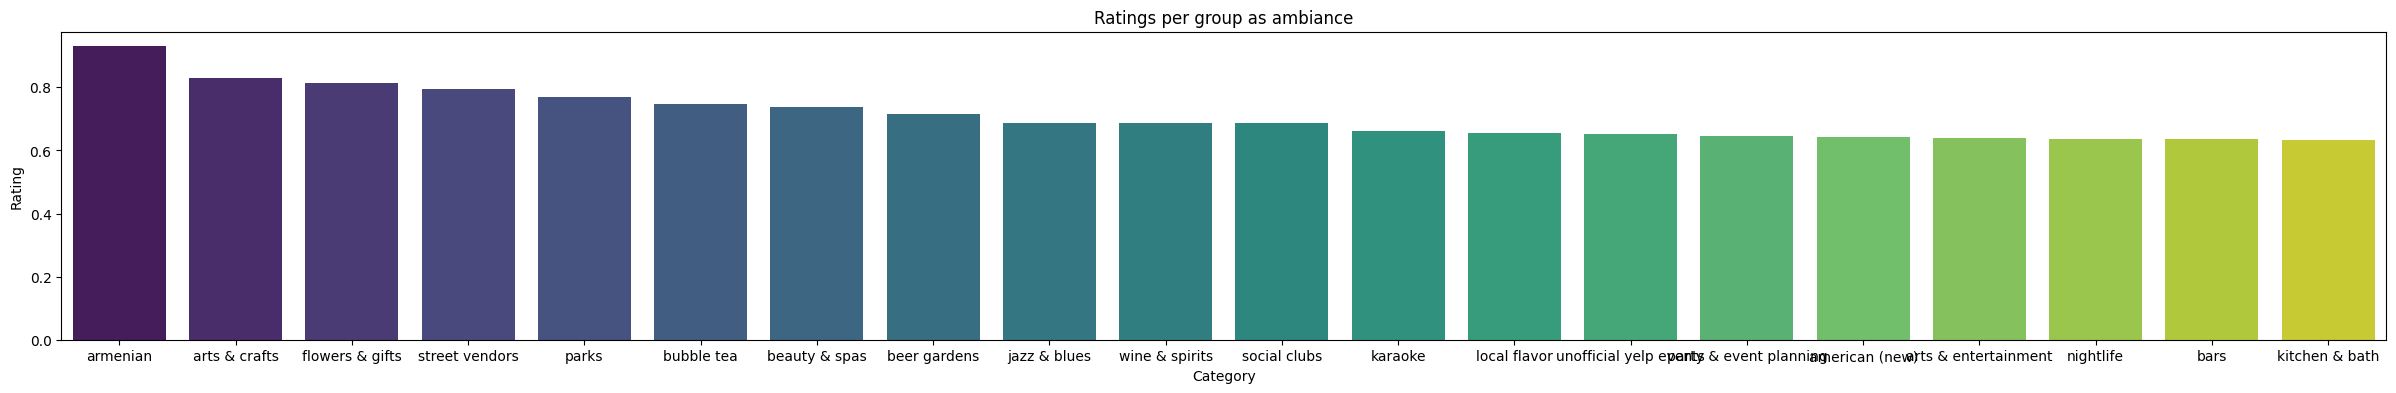

C:\Users\ady\AppData\Local\Temp\ipykernel_13592\874120165.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="categories_list", y="sentiment", data=df_filt[:20], palette="viridis")


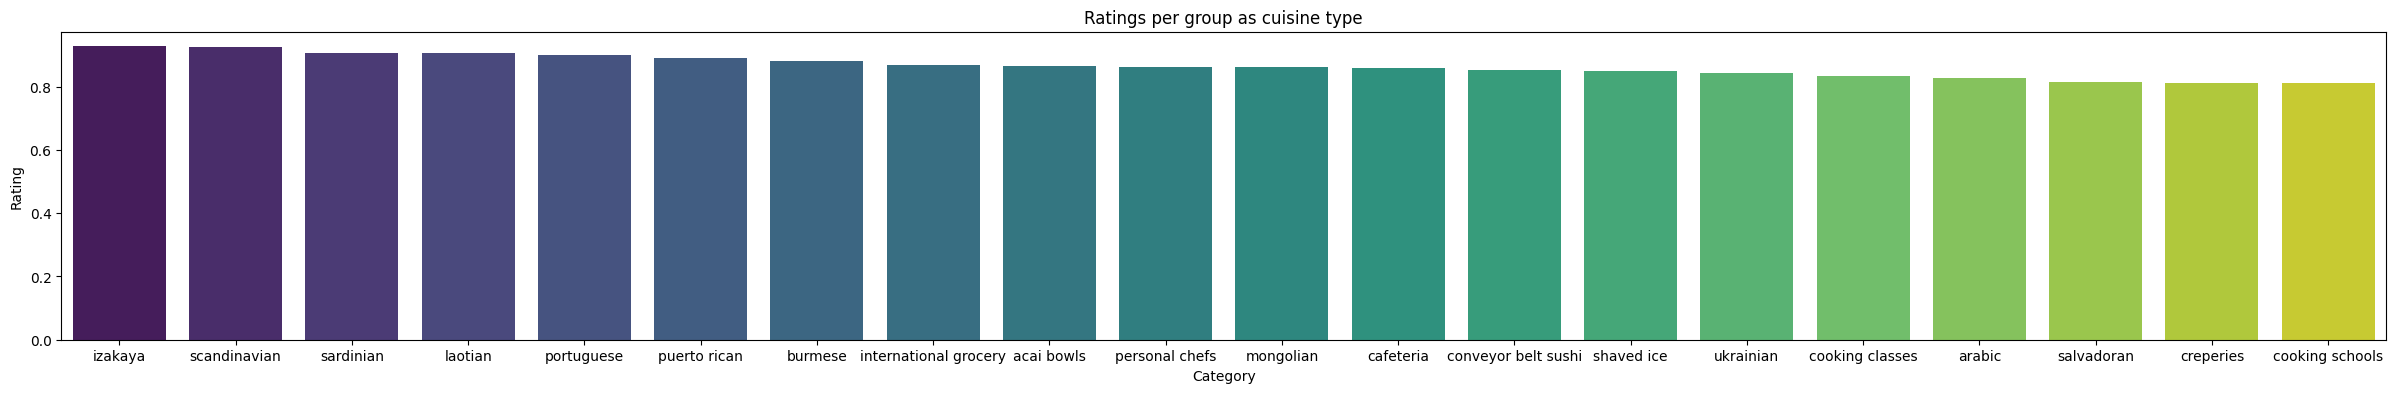

C:\Users\ady\AppData\Local\Temp\ipykernel_13592\874120165.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="categories_list", y="sentiment", data=df_filt[:20], palette="viridis")


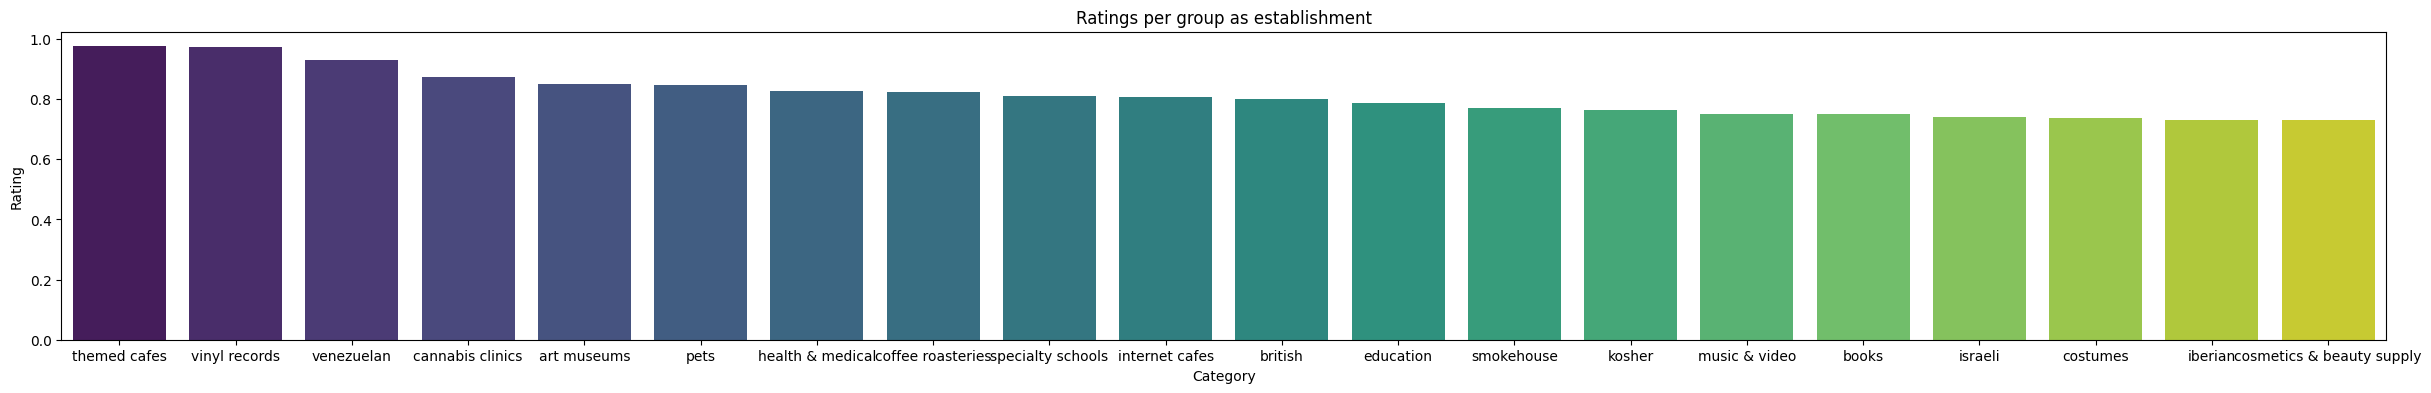

In [ ]:
# Extend dataframe by replicating obbservation according to "useful" value
df_useful_category = categories_individ_df.loc[np.repeat(categories_individ_df.index, categories_individ_df["useful"])].reset_index()

# Compute a mean per category
mean_sent_category = df_useful_category.groupby(["group_categorie", "categories_list"])["sentiment"].mean().reset_index()
mean_sent_category.sort_values(by="sentiment", ascending=False)


# Barplots per category and sentiment
for group in mean_sent_category["group_categorie"].unique():
    df_filt = mean_sent_category[mean_sent_category["group_categorie"] == group]
    df_filt[["categories_list", "sentiment"]]
    df_filt = df_filt.sort_values(by=["sentiment"], ascending=False)

    plt.figure(figsize=(30, 4))
    plt.title(f"Sentiment score per group as {group}")
    sns.barplot(x="categories_list", y="sentiment", data=df_filt[:20], palette="viridis")
    plt.xlabel("Category")
    plt.ylabel("Sentiment")
    plt.show()

We note that this approach brings the score closer to 0.5, so we tend to find homogeneous results as for ratings.

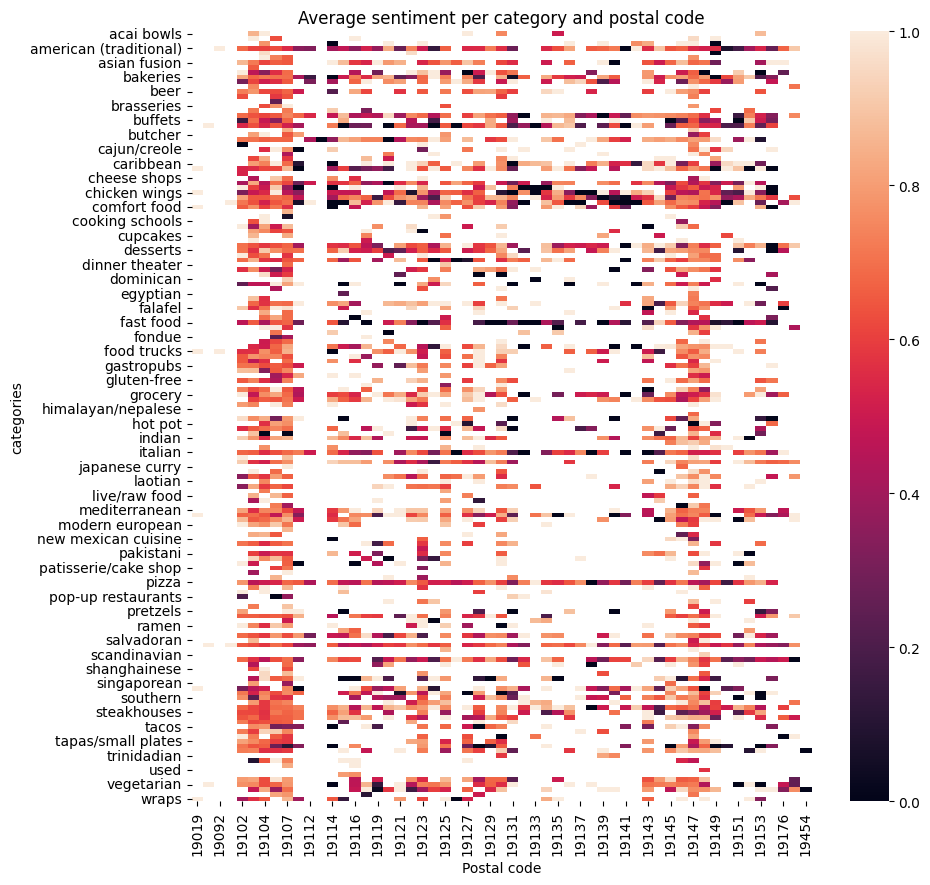

In [ ]:
# Heat map per postal code
cuisine_df = df_useful_category[df_useful_category["group_categorie"] == "cuisine type"]
df_postalcode = cuisine_df.groupby(["categories_list", "postal_code"])["sentiment"].mean().reset_index()
plt.figure(figsize=(10, 10))
sns.heatmap(df_postalcode.pivot(index="categories_list", columns="postal_code", values="sentiment"))
plt.title("Average sentiment per category and postal code")
plt.xlabel("Postal code")
plt.ylabel("categories")
plt.show()

#### Approach 2 - Focus on attributes

We replicate the experience, but for attributes and replicating the same treatment on useful reviews.

C:\Users\ady\AppData\Local\Temp\ipykernel_13592\3948396084.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  attribute_individ_df["sentiment"] = attribute_individ_df["sentiment"].replace("POSITIVE", 1)
C:\Users\ady\AppData\Local\Temp\ipykernel_13592\3948396084.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes_list", y="sentiment", data=df_filt[:20], palette="viridis")


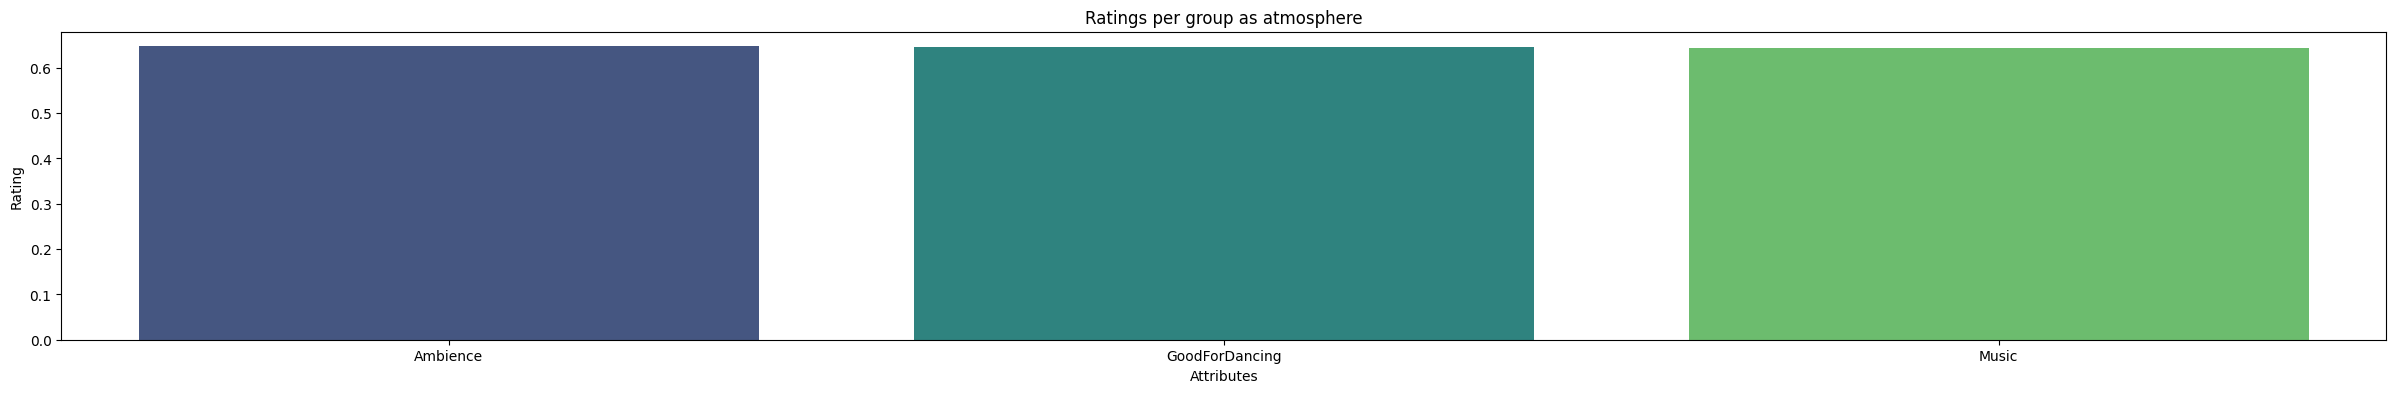

C:\Users\ady\AppData\Local\Temp\ipykernel_13592\3948396084.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes_list", y="sentiment", data=df_filt[:20], palette="viridis")


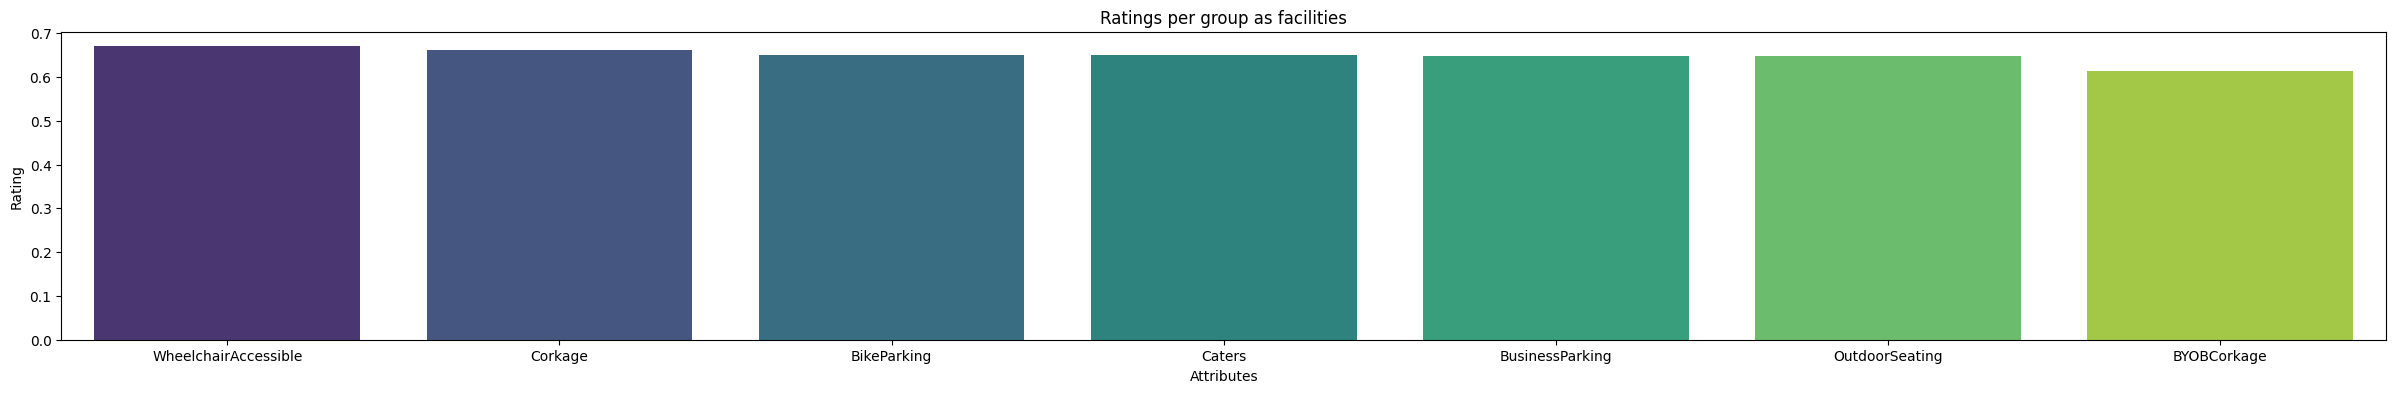

C:\Users\ady\AppData\Local\Temp\ipykernel_13592\3948396084.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes_list", y="sentiment", data=df_filt[:20], palette="viridis")


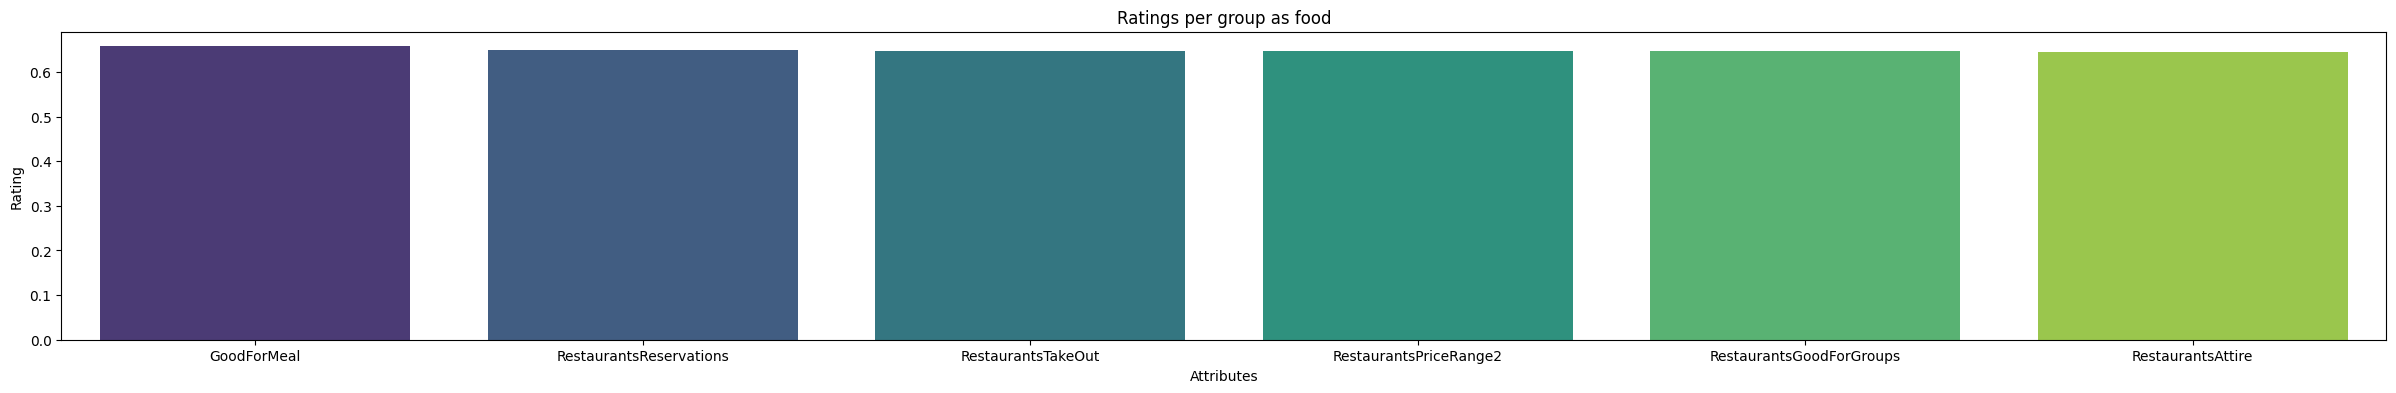

C:\Users\ady\AppData\Local\Temp\ipykernel_13592\3948396084.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes_list", y="sentiment", data=df_filt[:20], palette="viridis")


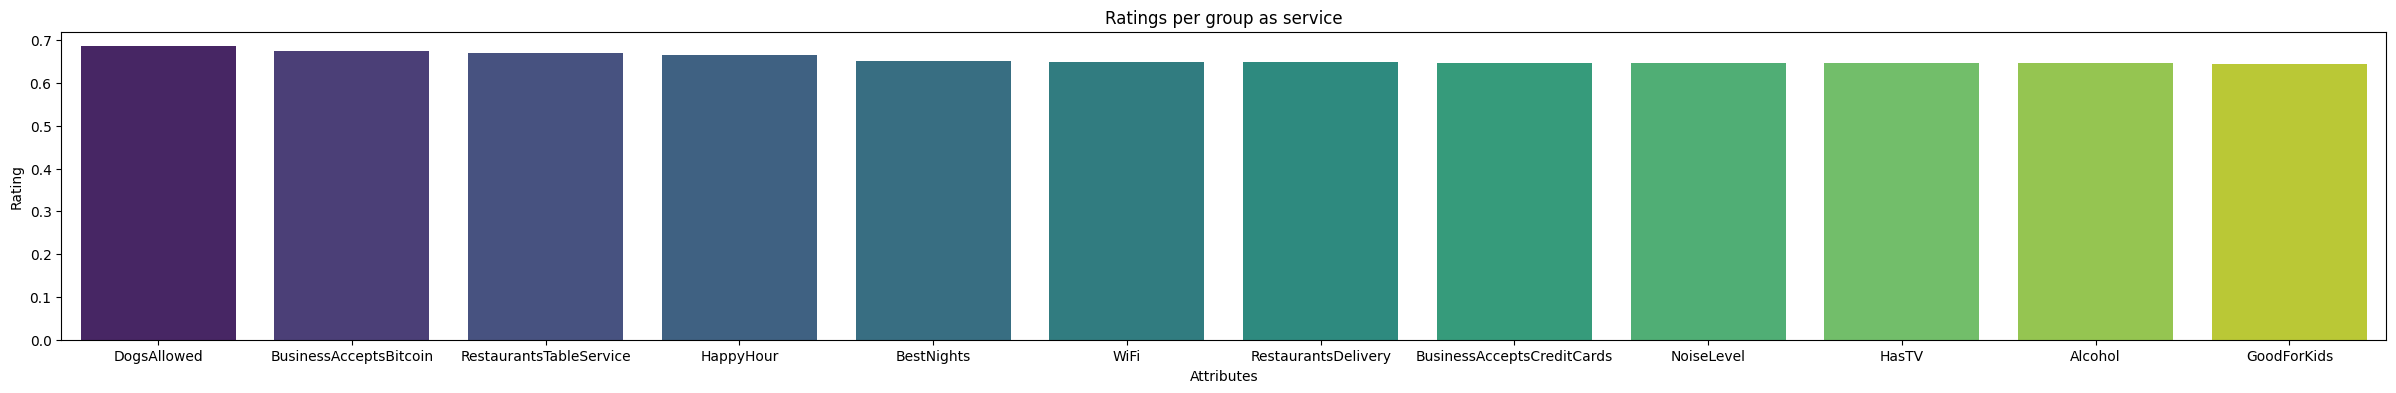

In [ ]:
# Compute a mean sentiment per attribute
attribute_individ_df.drop(attribute_individ_df[attribute_individ_df['sentiment'] == "None"].index, inplace = True)
attribute_individ_df["sentiment"] = attribute_individ_df["sentiment"].replace("NEGATIVE", 0)
attribute_individ_df["sentiment"] = attribute_individ_df["sentiment"].replace("POSITIVE", 1)

df_useful_attribute = attribute_individ_df.loc[np.repeat(attribute_individ_df.index, attribute_individ_df["useful"])].reset_index()

mean_sent_attribute = df_useful_attribute.groupby(["group_attribute", "attributes_list"])["sentiment"].mean().reset_index()
mean_sent_attribute.sort_values(by="sentiment", ascending=False)
mean_sent_attribute

# Barplots per category and sentiment
for group in mean_sent_attribute["group_attribute"].unique():
    df_filt = mean_sent_attribute[mean_sent_attribute["group_attribute"] == group]
    df_filt[["attributes_list", "sentiment"]]
    df_filt = df_filt.sort_values(by=["sentiment"], ascending=False)

    plt.figure(figsize=(30, 4))
    plt.title(f"Sentiment score per group as {group}")
    sns.barplot(x="attributes_list", y="sentiment", data=df_filt[:20], palette="viridis")
    plt.xlabel("Attribute")
    plt.ylabel("Sentiment")
    plt.show()

In order to extract the maximum amount of information from our data set, we wanted to take advantage of the "useful" variable. Thus, our hypothesis is that a person who gives a "useful" vote finds the respective review relevant. It means that either the person has not visited the restaurant yet and she has learned something useful, or she has visited it and she share the opinion in the review. As such, it is a quality metric that we would like to use to hilight insights.

In the analysis above, we sought to explore insights in the datasets targeted at Philadelphia using NLP methods and statistical calculations. Our approach is based on a quantitative and qualitative view of reviews linked to "attributes" and "categories" by business. This gives us an appreciative idea of the importance of different ratings. As the problem seeks to discover what is liked by consumers, we refined our analysis to consider only reviews classified as positive. We continued by groupping the categories and attributes by factors (groups) to get a more precise view of similar variables in our analysis. 

Next, we ...

#### Approach 3 - Keeping reviews given by more qualitative people

As scores seem to be homogene, we need to go deeper in the exploration by considering customer quality this time. Having fans useful reviews is a factor of credibility as well. We will filter the reviews to keep only those provided by people having provided by ustomers having a profile with at least 1 useful review and at least 1 fan. This filter reduces the total number of reviews of almost 50%. It is not an issue as the sample remain big enough. We migh have a better view on distinguishing quality. 


In [ ]:
# Filter the df dataset based on quality of users
df_users = pd.read_csv("data/ATML2024_users.csv", header=0)
df_users = df_users[["user_id", "useful", "fans"]]
df_users = df_users[(df_users["useful"] >= 1) & (df_users["fans"] >= 1)]
df_UserQuality_atr = attribute_individ_df[attribute_individ_df["user_id"].isin(df_users["user_id"].unique())]
df_UserQuality_cat = categories_individ_df[categories_individ_df["user_id"].isin(df_users["user_id"].unique())]

C:\Users\ady\AppData\Local\Temp\ipykernel_13592\3101993001.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_UserQuality_cat["sentiment"] = df_UserQuality_cat["sentiment"].replace("NEGATIVE", 0)
C:\Users\ady\AppData\Local\Temp\ipykernel_13592\3101993001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_UserQuality_cat["sentiment"] = df_UserQuality_cat["sentiment"].replace("POSITIVE", 1)
C:\Users\ady\AppData\Local\Temp\ipykernel_13592\3101993001.py:20: FutureWarning: 

Passing `palette` without ass

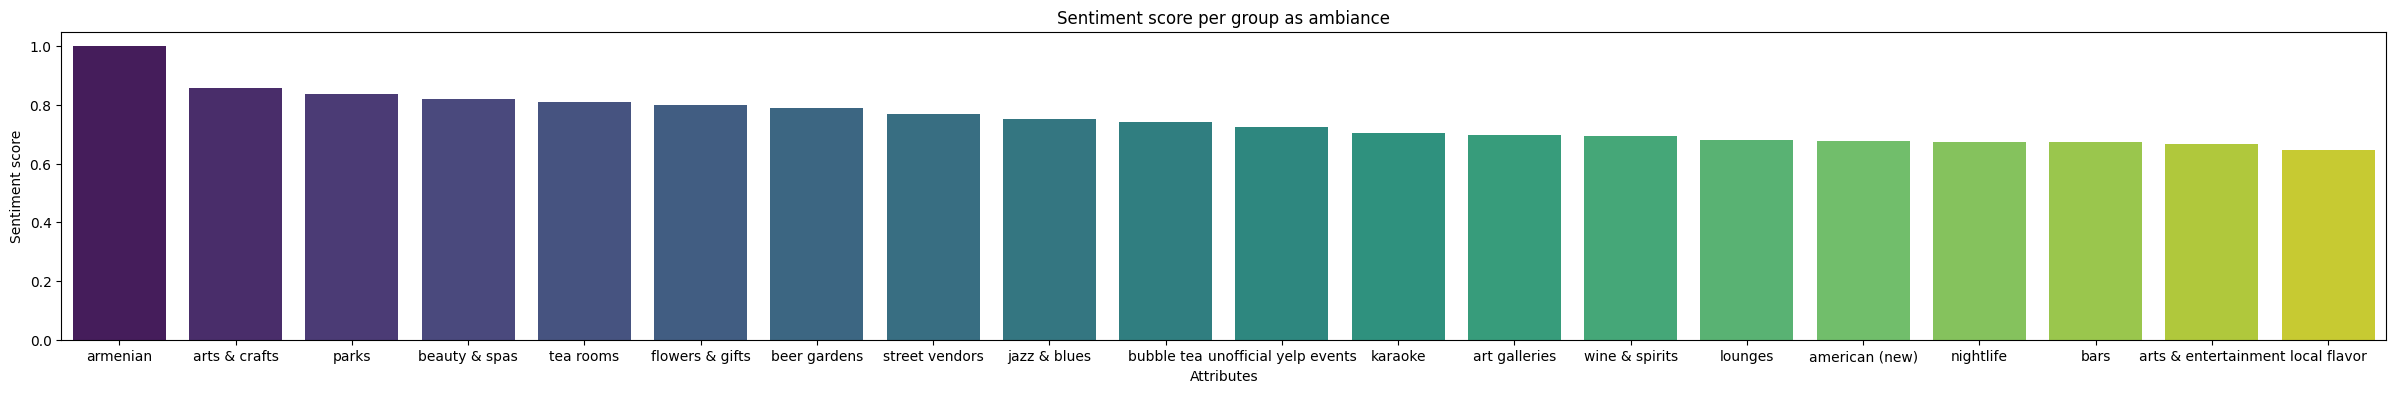

C:\Users\ady\AppData\Local\Temp\ipykernel_13592\3101993001.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="categories_list", y="sentiment", data=df_filt[:20], palette="viridis")


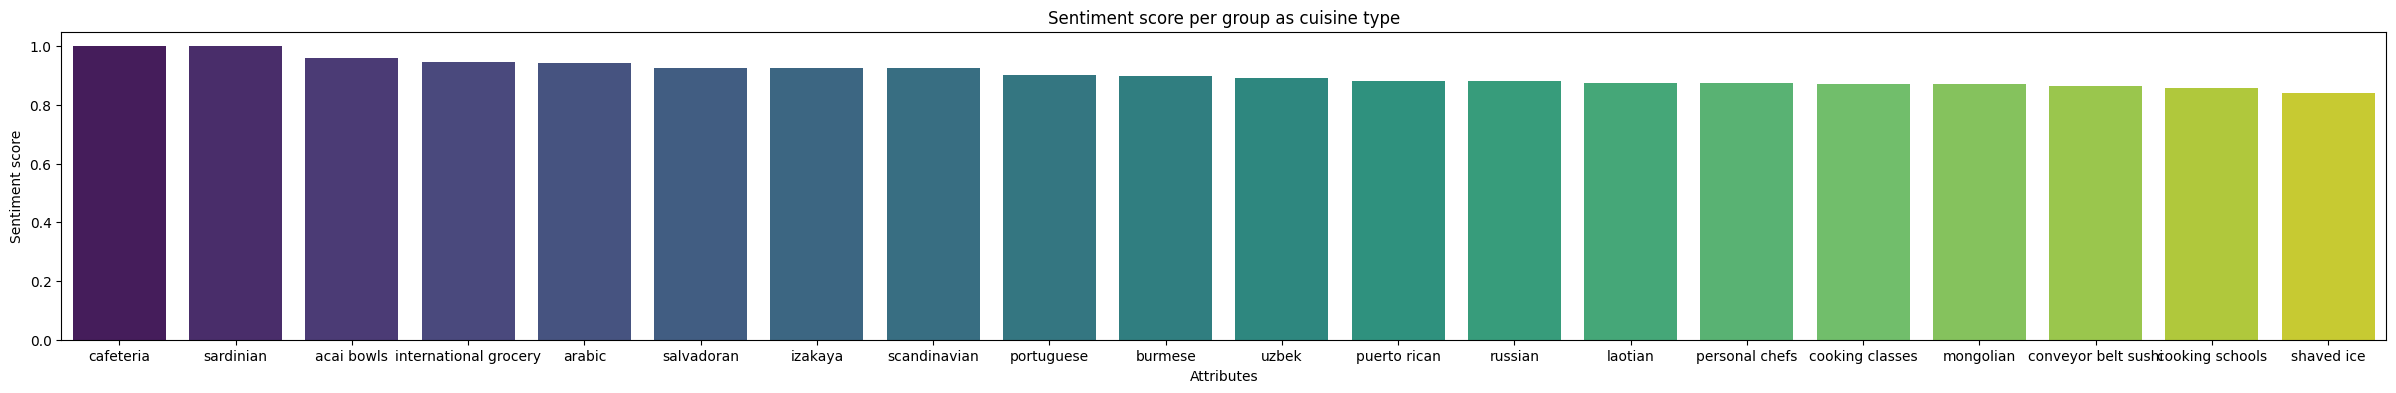

C:\Users\ady\AppData\Local\Temp\ipykernel_13592\3101993001.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="categories_list", y="sentiment", data=df_filt[:20], palette="viridis")


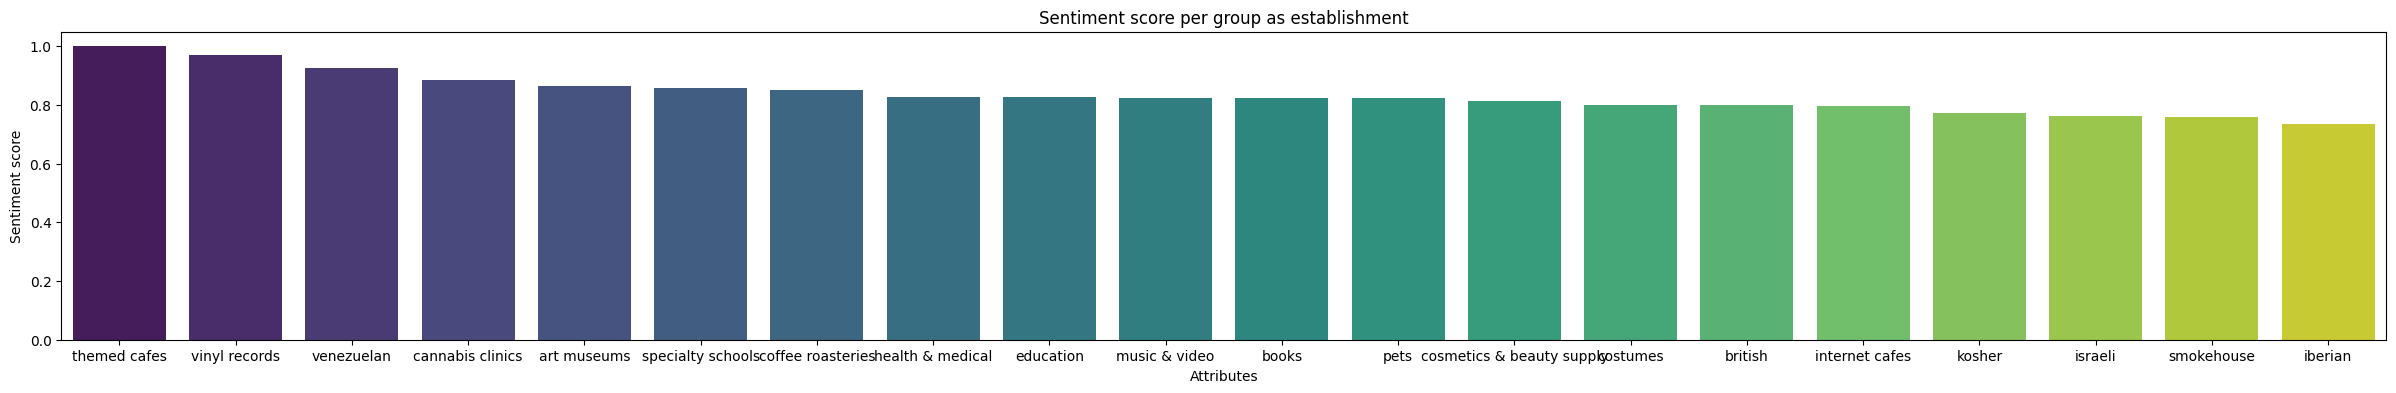

C:\Users\ady\AppData\Local\Temp\ipykernel_13592\3101993001.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_UserQuality_atr["sentiment"] = df_UserQuality_atr["sentiment"].replace("NEGATIVE", 0)
C:\Users\ady\AppData\Local\Temp\ipykernel_13592\3101993001.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_UserQuality_atr["sentiment"] = df_UserQuality_atr["sentiment"].replace("POSITIVE", 1)
C:\Users\ady\AppData\Local\Temp\ipykernel_13592\3101993001.py:46: FutureWarning: 

Passing `palette` without a

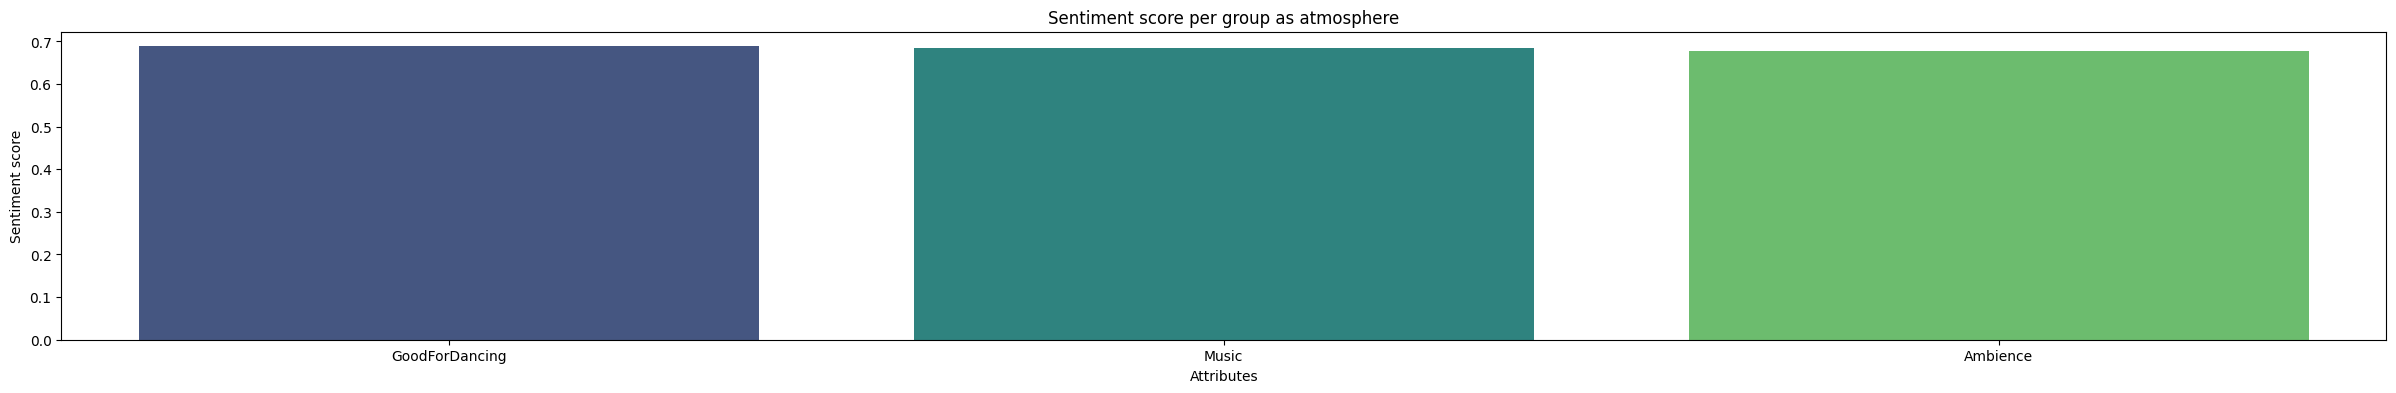

C:\Users\ady\AppData\Local\Temp\ipykernel_13592\3101993001.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes_list", y="sentiment", data=df_filt[:20], palette="viridis")


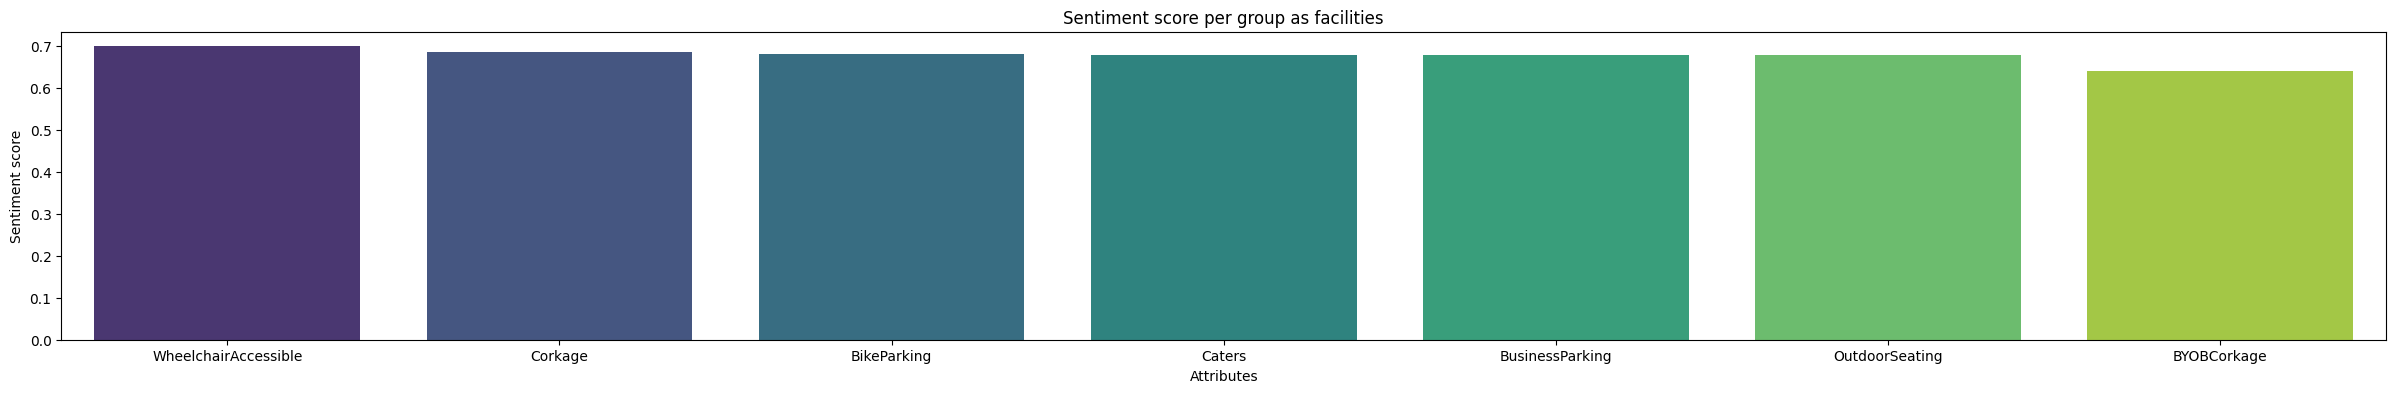

C:\Users\ady\AppData\Local\Temp\ipykernel_13592\3101993001.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes_list", y="sentiment", data=df_filt[:20], palette="viridis")


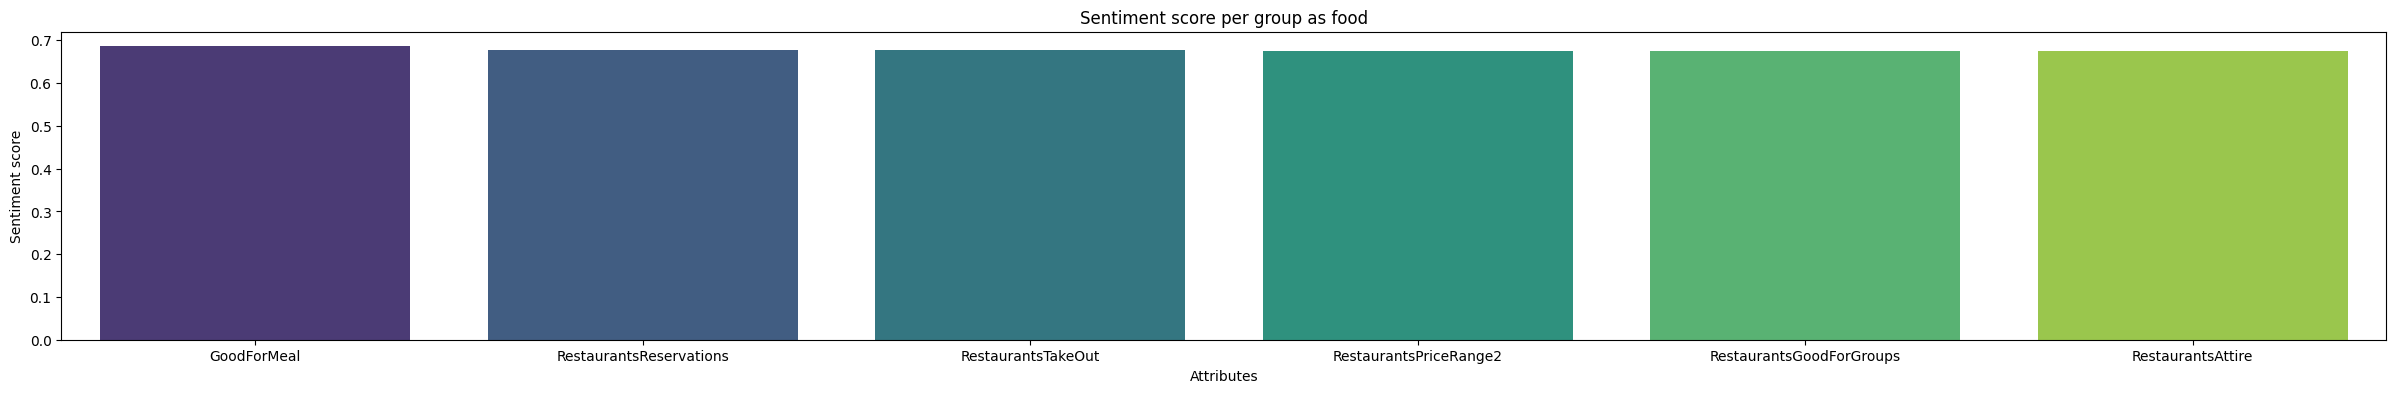

C:\Users\ady\AppData\Local\Temp\ipykernel_13592\3101993001.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes_list", y="sentiment", data=df_filt[:20], palette="viridis")


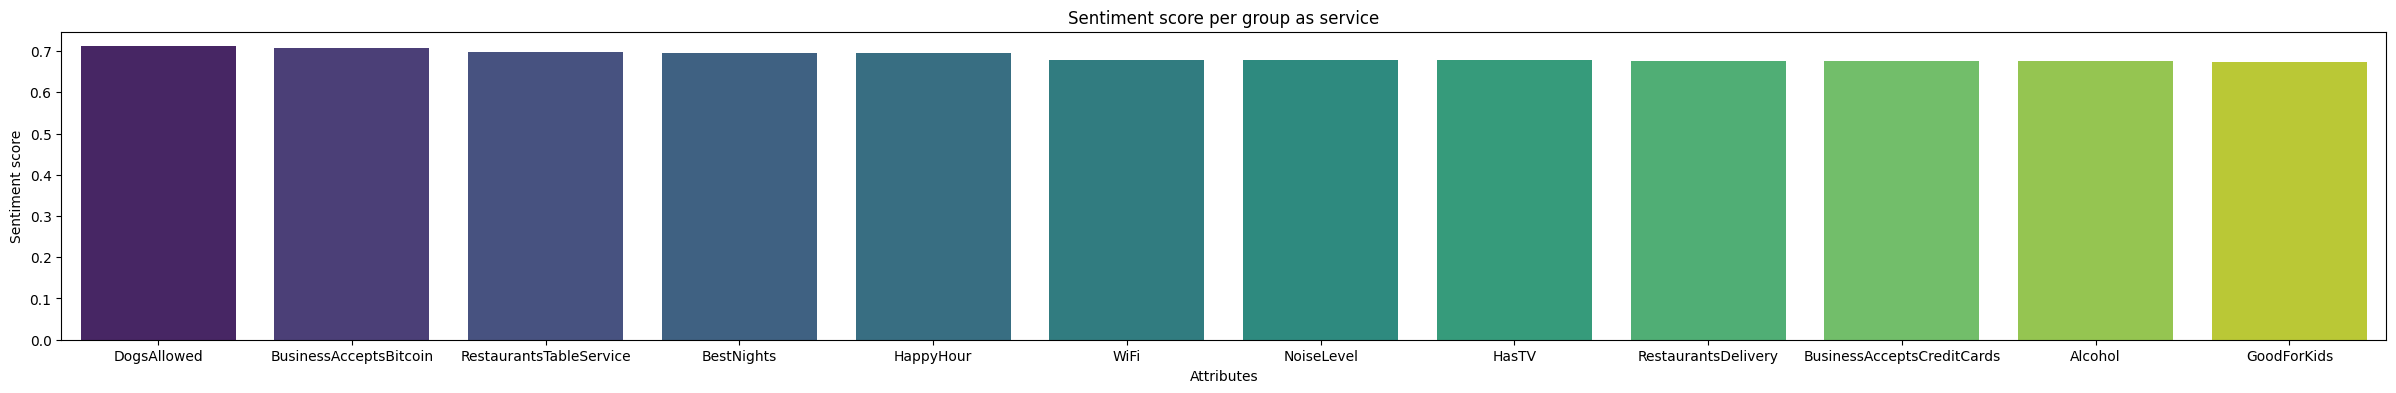

In [ ]:
##################################################################
# Compute a mean sentiment score per category
df_UserQuality_cat["sentiment"] = df_UserQuality_cat["sentiment"].replace("NEGATIVE", 0)
df_UserQuality_cat["sentiment"] = df_UserQuality_cat["sentiment"].replace("POSITIVE", 1)

# Replicate observations based on "useful"
df_UserQuality_cat = df_UserQuality_cat.loc[np.repeat(df_UserQuality_cat.index, df_UserQuality_cat["useful"])].reset_index()

mean_sent_category = df_UserQuality_cat.groupby(["group_categorie", "categories_list"])["sentiment"].mean().reset_index()
mean_sent_category.sort_values(by="sentiment", ascending=False)

# Barplots per category and sentiment
for group in mean_sent_category["group_categorie"].unique():
    df_filt = mean_sent_category[mean_sent_category["group_categorie"] == group]
    df_filt[["categories_list", "sentiment"]]
    df_filt = df_filt.sort_values(by=["sentiment"], ascending=False)

    plt.figure(figsize=(30, 4))
    plt.title(f"Sentiment score per group as {group}")
    sns.barplot(x="categories_list", y="sentiment", data=df_filt[:20], palette="viridis")
    plt.xlabel("Category")
    plt.ylabel("Sentiment")
    plt.show()


##################################################################
# Compute a mean sentiment per attribute
df_UserQuality_atr["sentiment"] = df_UserQuality_atr["sentiment"].replace("NEGATIVE", 0)
df_UserQuality_atr["sentiment"] = df_UserQuality_atr["sentiment"].replace("POSITIVE", 1)

# Replicate observations based on "useful"
df_useful_attribute = df_UserQuality_atr.loc[np.repeat(df_UserQuality_atr.index, df_UserQuality_atr["useful"])].reset_index()

mean_sent_attribute = df_useful_attribute.groupby(["group_attribute", "attributes_list"])["sentiment"].mean().reset_index()
mean_sent_attribute.sort_values(by="sentiment", ascending=False)
mean_sent_attribute

# Barplots per attribute and sentiment
for group in mean_sent_attribute["group_attribute"].unique():
    df_filt = mean_sent_attribute[mean_sent_attribute["group_attribute"] == group]
    df_filt[["attributes_list", "sentiment"]]
    df_filt = df_filt.sort_values(by=["sentiment"], ascending=False)

    plt.figure(figsize=(30, 4))
    plt.title(f"Sentiment score per group as {group}")
    sns.barplot(x="attributes_list", y="sentiment", data=df_filt[:20], palette="viridis")
    plt.xlabel("Attributes")
    plt.ylabel("Sentiment score")
    plt.show()

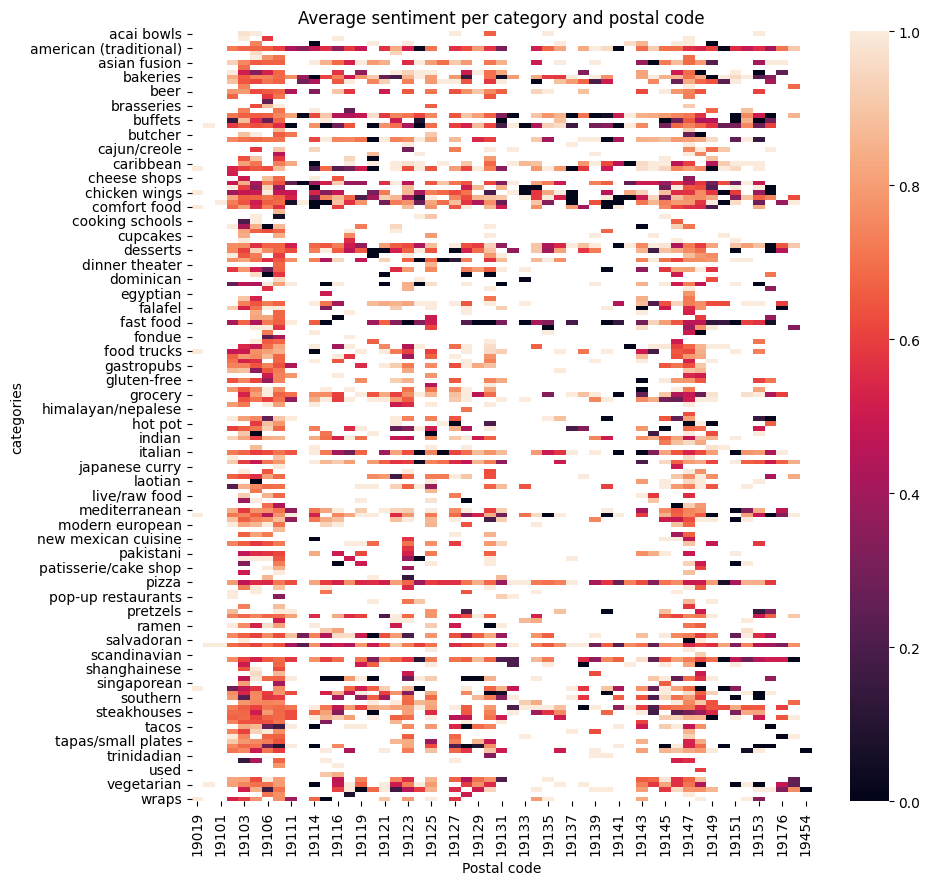

In [ ]:
# Heat map per postal code
cuisine_df = df_UserQuality_cat[df_UserQuality_cat["group_categorie"] == "cuisine type"]
df_postalcode = cuisine_df.groupby(["categories_list", "postal_code"])["sentiment"].mean().reset_index()
plt.figure(figsize=(10, 10))
sns.heatmap(df_postalcode.pivot(index="categories_list", columns="postal_code", values="sentiment"))
plt.title("Average sentiment per category and postal code")
plt.xlabel("Postal code")
plt.ylabel("categories")
plt.show()

Having compared the results of this method with those of previous ones, we notice that the results are rather similar. Even though we have lost a lot of reviews, we note that preferences remain the same.

C:\Users\ady\AppData\Local\Temp\ipykernel_13592\2758572468.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="categories_list", y="rating", data=df_filt[:20], palette="viridis")


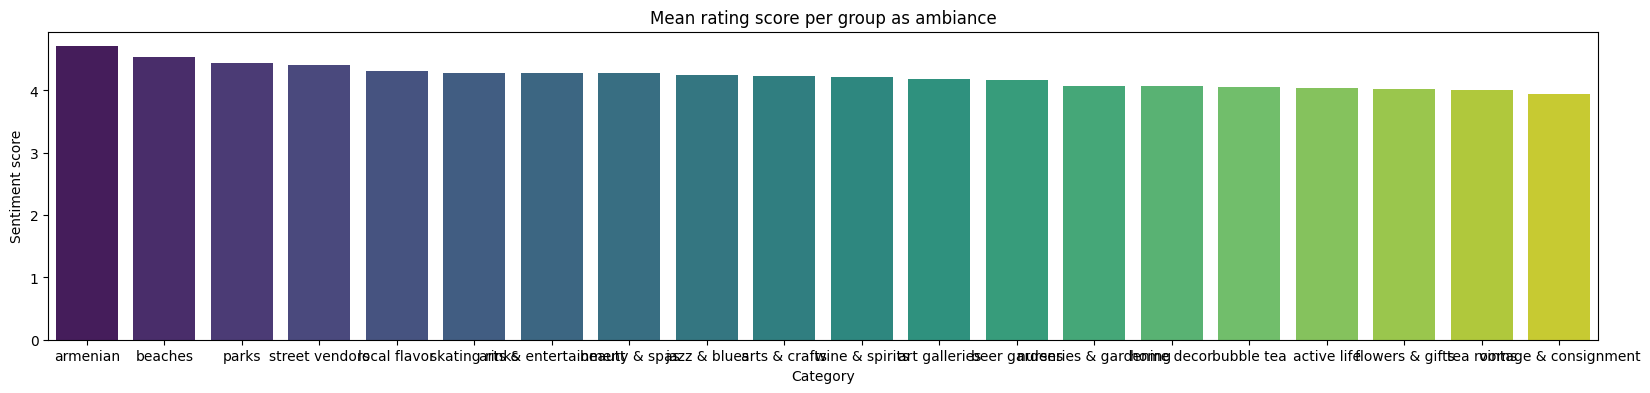

C:\Users\ady\AppData\Local\Temp\ipykernel_13592\2758572468.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="categories_list", y="rating", data=df_filt[:20], palette="viridis")


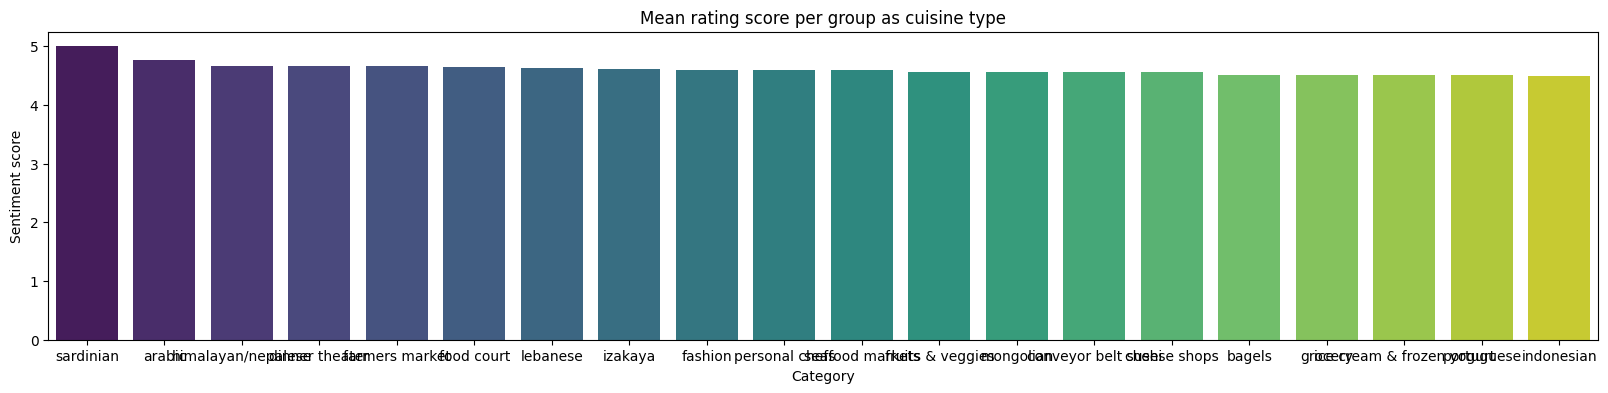

C:\Users\ady\AppData\Local\Temp\ipykernel_13592\2758572468.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="categories_list", y="rating", data=df_filt[:20], palette="viridis")


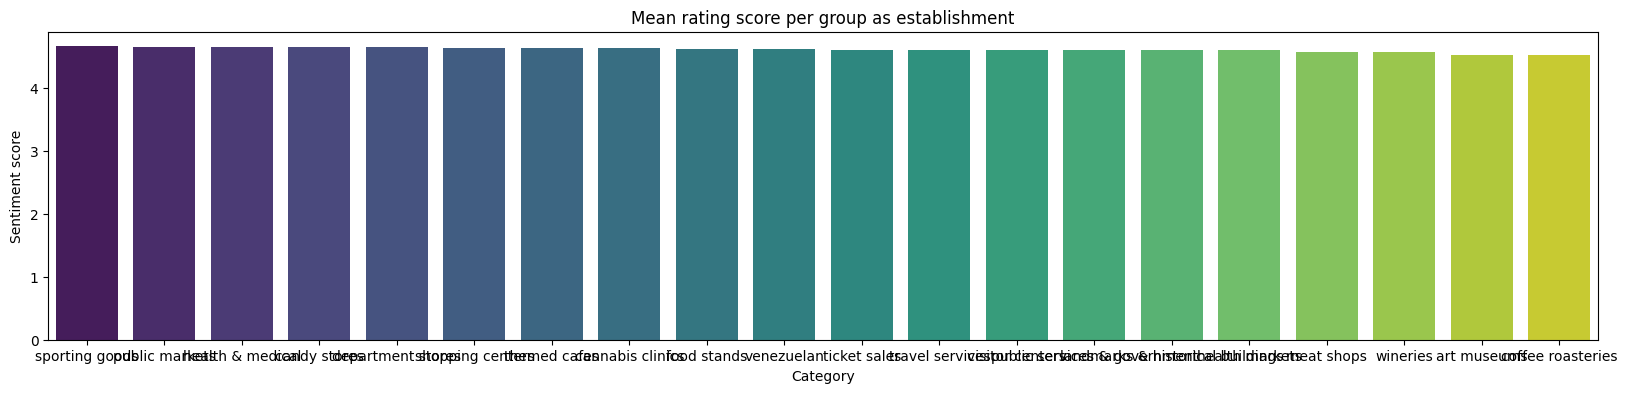

C:\Users\ady\AppData\Local\Temp\ipykernel_13592\2758572468.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes_list", y="rating", data=df_filt[:20], palette="viridis")


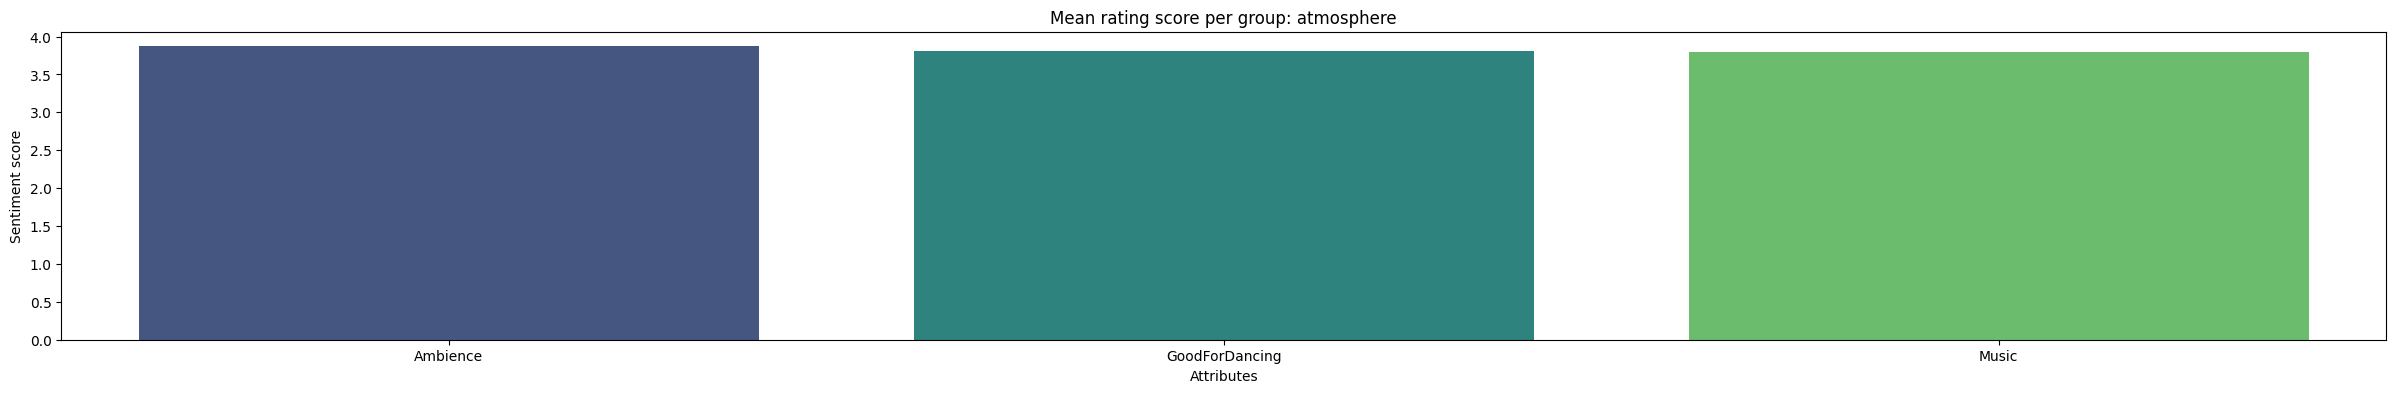

C:\Users\ady\AppData\Local\Temp\ipykernel_13592\2758572468.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes_list", y="rating", data=df_filt[:20], palette="viridis")


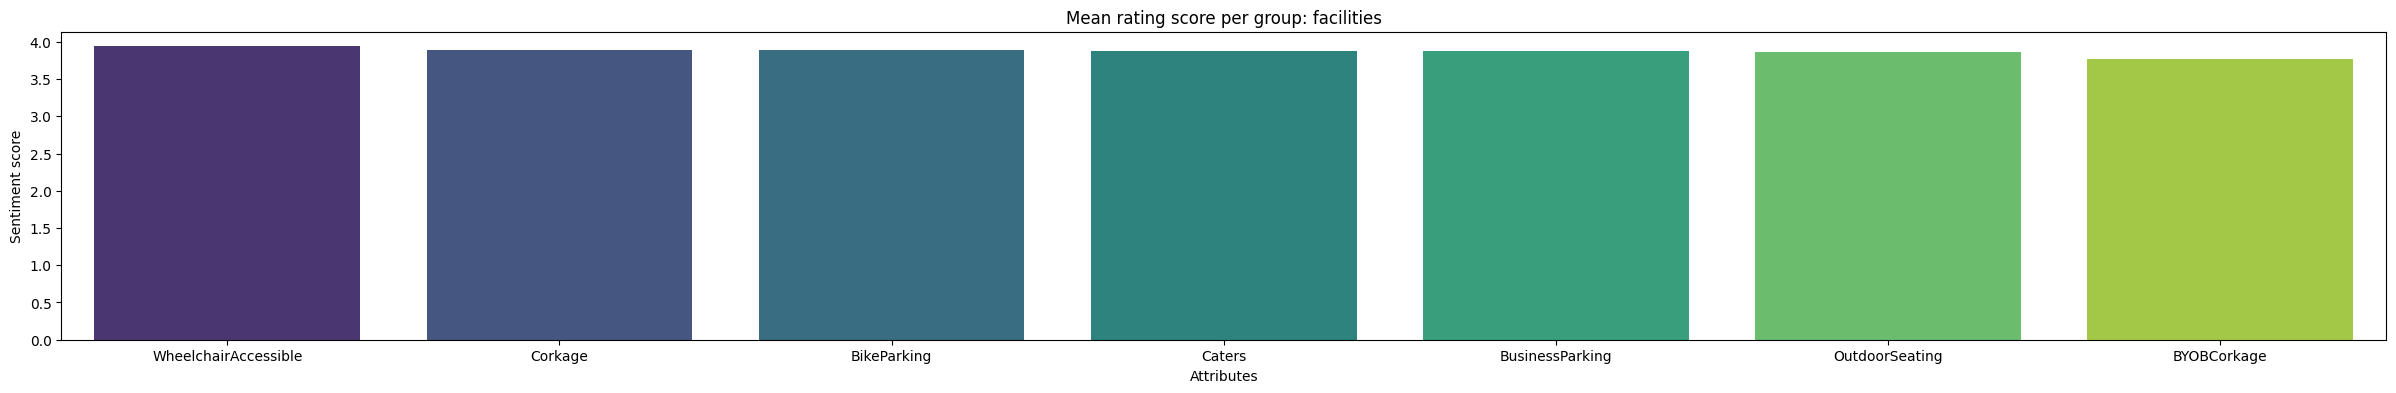

C:\Users\ady\AppData\Local\Temp\ipykernel_13592\2758572468.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes_list", y="rating", data=df_filt[:20], palette="viridis")


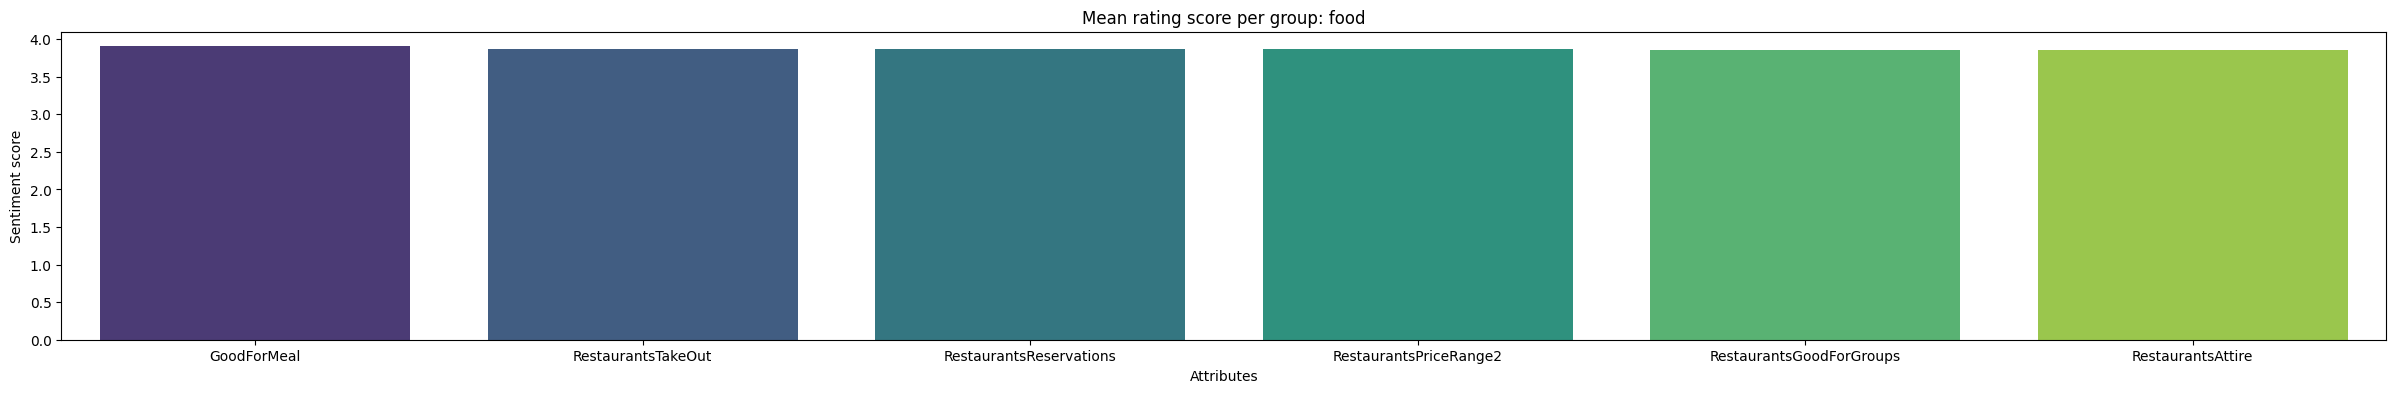

C:\Users\ady\AppData\Local\Temp\ipykernel_13592\2758572468.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="attributes_list", y="rating", data=df_filt[:20], palette="viridis")


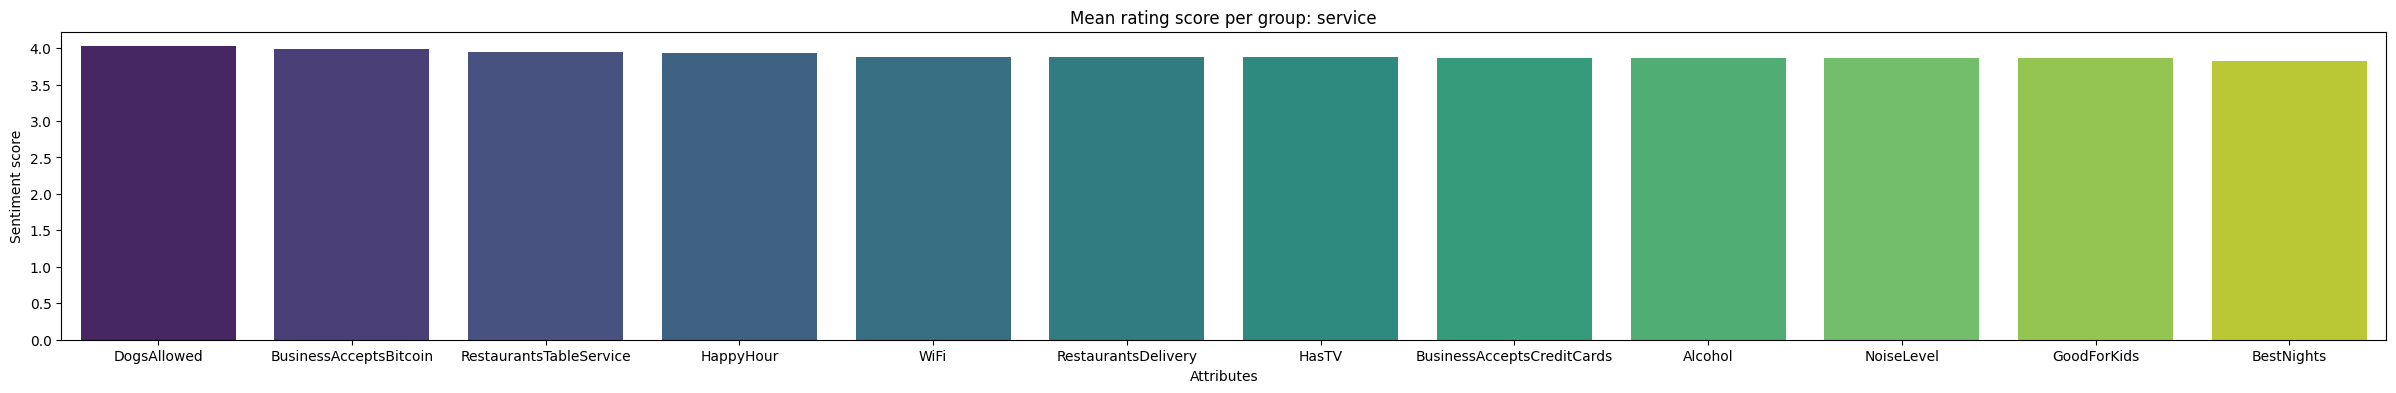

In [ ]:
# Compute a mean rating score per category
mean_sent_category = df_UserQuality_cat.groupby(["group_categorie", "categories_list"])["rating"].mean().reset_index()
mean_sent_category.sort_values(by="rating", ascending=False)

# Barplots per category and rating
for group in mean_sent_category["group_categorie"].unique():
    df_filt = mean_sent_category[mean_sent_category["group_categorie"] == group]
    df_filt[["categories_list", "rating"]]
    df_filt = df_filt.sort_values(by=["rating"], ascending=False)

    plt.figure(figsize=(20, 4))
    plt.title(f"Mean sentiment score per group as {group}")
    sns.barplot(x="categories_list", y="rating", data=df_filt[:20], palette="viridis")
    plt.xlabel("Category")
    plt.ylabel("Sentiment score")
    plt.show()


# Compute a mean rating per attribute
mean_sent_attribute = df_useful_attribute.groupby(["group_attribute", "attributes_list"])["rating"].mean().reset_index()
mean_sent_attribute.sort_values(by="rating", ascending=False)

# Barplots per category and rating
for group in mean_sent_attribute["group_attribute"].unique():
    df_filt = mean_sent_attribute[mean_sent_attribute["group_attribute"] == group]
    df_filt[["attributes_list", "rating"]]
    df_filt = df_filt.sort_values(by=["rating"], ascending=False)

    plt.figure(figsize=(30, 4))
    plt.title(f"Mean sentiment score per group {group}")
    sns.barplot(x="attributes_list", y="rating", data=df_filt[:20], palette="viridis")
    plt.xlabel("Attribute")
    plt.ylabel("Sentiment")
    plt.show()

The results are rather similar to the barplots for attributes seen earlier.
In the group facilities: having wheelchair accessibleand corkage are appreciated.
In the group food: good for meal, reservations and take out, are liked.
In the group service: Dogs allowed and bitcoin acceptance are liked.

## 2.1.3 Conclusion on insights

Generally speaking, it seems that consumers tend to appreciate things in the same way through filtering. There are some nuances, but they seem negligible when we focus on the top 20 items, considering a rational or sentimental score. 

We note the following trends in the top rankings. These are restaurants associated with relaxation, sociability and open-mindedness. In addition, all services are globally appreciated. In a way, the more the better... in terms of facilities too... 

In order to extract insights, it therefore seems worthwhile to propose a look based on frequencies and heat maps, and on what should rather be avoided. 

This point will be presented in task 2.1.3 as this one focus on what is generally liked by consumers.
